# ODE   model of NeuroImaging With Bayesian Inference in Multiple Ways

:::{post} April 8, 2024
:tags: ODE, PyTensor, gradient-free inference
:category: Advanced, how-to
:author: Meysam HASHEMI, INS, AMU, Marseille.
:::

Note: This notebook is adpated from PyMC's ODE models, written by Greg Brunkhorst. 
See: 
https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html

In [1]:
import os
import sys
import errno
import time

import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt


from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

import arviz as az
import matplotlib.pyplot as plt

In [2]:
print(f"Running on PyMC v{pm.__version__}")
print(f"Running on Pytensor v{pytensor.__version__}")
print(f"Running on Numpy v{np.__version__}")
print(f"Running on Arviz v{az.__version__}")

Running on PyMC v5.11.0
Running on Pytensor v2.18.6
Running on Numpy v1.25.2
Running on Arviz v0.18.0


In [3]:
%load_ext watermark
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

In [4]:
import os
import sys
cwd = os.getcwd()
output_dir= cwd + '/output_pymc/'
! mkdir -p $output_dir

/bin/bash: /home/meysam/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Purpose

The purpose of this notebook is to demonstrate how to perform Bayesian inference on a system of ordinary differential equations (ODEs), both with and without gradients. The code is adapted from PyMC ODE examples (Ref [1]).   The accuracy and efficiency of different samplers are compared. The application is to model and fit neuroimaging data such as ERP/EEG/MEG recording (see Ref [2]).

Although recently have been some effort to Bayesian inversion of this model in dynamic causal modeling Refs [3,4], here we benifit from automatic algorithms and automatic gradient calculation in PPLs such as PyMC.

We will first present the adapted Jansen-Rit ODE model and example synthetic data.  Next, we will solve the ODE using `scipy.odeint` and (non-Bayesian) least squares optimization.  Next, we perform Bayesian inference in PyMC using non-gradient-based samplers.  Finally, we use gradient-based samplers and compare results.    

### Key Conclusions

Based on the experiments in this notebook, the most simple and efficient method for performing Bayesian inference on this model was to specify the ODE system in Scipy, wrap the function as a Pytensor op, and use a ?  sampler in PyMC.  

Refs: 

1) https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html


2) https://www.sciencedirect.com/science/article/abs/pii/S1053811905008013


3) https://www.sciencedirect.com/science/article/pii/S1053811915001846


4) https://www.sciencedirect.com/science/article/pii/S1053811915006540


## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using PyMC. The apadted Jansen-Rit model used in this example has often been used in dynamical cuasal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model 


The mode of olivier david et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

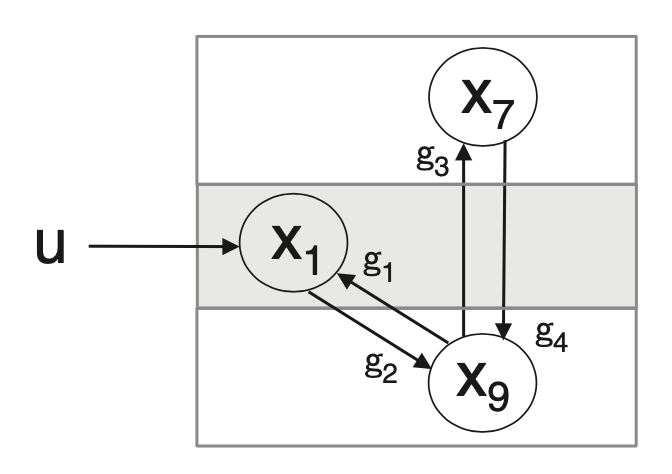

In [5]:
from IPython.display import Image
Image(filename='model.png', width=400) 

This ODE given by:




\begin{array}{l}
\frac{dx_{1}(t)}{dt} = x_{4}(t) \\
\frac{dx_{2}(t)}{dt} = x_{5}(t) \\
\frac{dx_{3}(t)}{dt} = x_{6}(t) \\
\frac{dx_{7}(t)}{dt}  = x_{8}(t) \\
\frac{dx_{4}(t)}{dt} = \frac{{h_{e}(g_{1}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5) + u)}}{{\tau_{e}}} - \frac{{x_{1}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{4}(t)}}{{\tau_{e}}} \\
\frac{dx_{5}(t)}{dt}  = \frac{{g_{2}(\frac{1}{e^{-0.56x_{1}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{2}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{5}(t)}}{{\tau_{e}}} \\
\frac{dx_{6}(t)}{dt}  = \frac{{g_{4}(\frac{1}{e^{-0.56x_{7}(t-\delta)}+1} - 0.5)}}{{\tau_{i}}} - \frac{{x_{3}(t)}}{{\tau_{i}^{2}}} - \frac{{2x_{6}^{t}}}{{\tau_{i}}} \\
\frac{dx_{8}(t)}{dt}  = \frac{{g_{3}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{7}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{8}(t)}}{{\tau_{e}}} \\
\frac{dx_{9}(t)}{dt}  = x_{5}(t) - x_{6}(t)
\end{array}



The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of nerural populations.  Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.  

$x(0)$ is the initial values of the states needed to solve the ODE, and are fixed to zero for all variables. 


The unknown model parameters which represent the following:  
* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ are maximum amplitude of excitatory (e), and inhibitory (i) post-synaptic potential.
* $\tau_{e, i}$ are the excitatory (e), and inhibitory (i) rate-constant of the membrane,
* $u$  is the input to the neural population.

### Set-up

In [6]:
params_labels=['$g_1$', '$g_2$', '$g_3$', '$g_4$', '$\delta$', '$tau_i$', '$h_i$', '$tau_e$','$h_e$', '$u$']
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

In [7]:
t0=0.0
tend = 200.0
dt=0.1
ts = np.arange(t0, tend + dt, dt)

In [8]:
n_time=ts.shape[0]
n_states=9
n_time, n_states

(2001, 9)

In [9]:
x_init=np.zeros((n_states))

In [10]:
g_1=0.42
g_2=0.76
g_3=0.15
g_4=0.16
delta=12.13
tau_e=7.77
h_i=27.87
tau_i=5.77
h_e=1.63
u=3.94

In [11]:
sigma_true=0.1

In [12]:
theta_true = np.array([g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u])
n_params = theta_true.shape[0]

In [13]:
c=-0.56
constants=np.array([c])

In [14]:
@njit
def Sigmodal(x1, x2, delta, c):
    S=(1./(1.+np.exp(c*(x1-(delta*x2)))))-0.5
    return S

## Scipy `odeint`

Here, we make a Python function that represents the right-hand-side of the ODE equations with the call signature needed for the `odeint` function.  Note that Scipy's `solve_ivp` could also be used, but the older `odeint` function was faster in speed tests and is therefore used in this notebook.  

In [15]:
# define the right hand side of the ODE equations in the Scipy odeint signature

@njit
def DCM_ERPmodel(states, t, params):
    
    # state variables
    x0, x1, x2, x3, x4, x5, x6, x7, x8 = states
    
    # unpack parameters
    g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u  = params

    #constants
    c = constants[0]
        
    # equations
    dx0_dt = x3
    dx1_dt = x4
    dx2_dt = x5
    dx3_dt = (1./tau_e) * (h_e * (g_1 * (Sigmodal(x8, x4 - x5, delta, c)) + u) - (x0 / tau_e) - 2 * x3)
    dx4_dt = (1./tau_e) * (h_e * (g_2 * (Sigmodal(x0, x3, delta, c))) - (x1 / tau_e) - 2 * x4)
    dx5_dt = (1./tau_i) * (h_i * (g_4 * (Sigmodal(x6, x7, delta, c))) - (x2 / tau_i) - 2 * x5)
    dx6_dt = x7
    dx7_dt = (1. / tau_e) * (h_e * (g_3 * (Sigmodal(x8, x4 - x5, delta, c))) - (x6 / tau_e) - 2 * x7)
    dx8_dt = x4 - x5
    
    return [dx0_dt, dx1_dt, dx2_dt, dx3_dt, dx4_dt, dx5_dt, dx6_dt, dx7_dt, dx8_dt]

To get a feel for the model and make sure the equations are working correctly, let's run the model once with reasonable values for $\theta$ and plot the results.  

In [16]:
# plot model function
def plot_model(ax, xs, ts=np.arange(t0, tend + dt, dt), alpha=1, lw=2, title="ERP and an Example Model Run",):
    ax.plot(ts, xs[:, 8], color="cornflowerblue", alpha=alpha, lw=lw, label="Pyramidal (Model)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax

In [17]:
theta = theta_true
ts = np.arange(t0, tend + dt, dt)

# call Scipy's odeint function
xs= odeint(DCM_ERPmodel, x_init, t=ts, args=(theta,))

### Synthetic observation

We assume that we only have accessto the activity of pyramidfal neurons, and for the sake of sppeding the computational time, we downsample the simuations.

In [18]:
#Downsamplinmg
ds=10

In [19]:
ts_obs=ts[::ds]
xpy_ds=xs[:, 8][::ds]

In [20]:
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_ds.shape[0])
xpy_obs = xpy_ds + x_noise

In [21]:
# fmt: off
data = pd.DataFrame(dict(
    ts_obs = ts_obs,
    pyramidal = xpy_obs,))
data.head()
# fmt: on

ts_obs  pyramidal
0     0.0  -0.025904
1     1.0   0.075307
2     2.0   0.013531
3     3.0  -0.254566
4     4.0  -0.292133

In [22]:
# plot data function for reuse later
def plot_data(ax, lw=0, title="Synthetic ERP data"):
    ax.plot(data.ts_obs, data.pyramidal, color="red", lw=lw, marker="x", markersize=4, label="Pyramidal (Data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([0, 200])
    ax.set_xlabel("time [ms]", fontsize=14)
    ax.set_ylabel("voltage [mv] ", fontsize=14)
    ax.set_title(title, fontsize=16)
    return ax

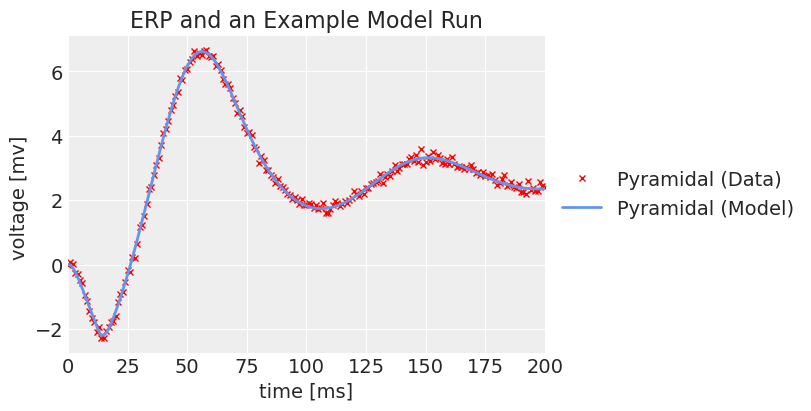

In [23]:
# plot
_, ax = plt.subplots(figsize=(8, 4))
plot_data(ax);
plot_model(ax, xs);

PPC

In [24]:
def rmse_fit(model, trace, data, theta_true):
#     with model:
#          pp = pm.sample_posterior_predictive(trace,  var_names=["xpy_obs"], predictions=True, random_seed=rng)
#          theta_err=np.sum((theta_true-az.summary(trace, var_names=my_var_names).values[:,0])**2)
#          x_ppc=np.mean(np.mean(pp.predictions['xpy_obs'][:,:,:,0], axis=0), axis=0)
#          xs_err=np.sum((x_ppc-data.pyramidal)**2)

    theta_mean=np.mean(az.extract(trace).to_dataframe()[my_var_names], axis=0).to_numpy()
    theta_err=np.sum(theta_mean-theta_true)**2
    xs_= odeint(DCM_ERPmodel, x_init, t=ts, args=(theta_mean,))
    xs_err=np.sum((xs_[:,8][::ds]-data["pyramidal"])**2)
    
    return (theta_err), np.mean(xs_err)

Looks like the `odeint` function is working as expected.  

## Least Squares Solution

Now, we can solve the ODE using least squares.  Make a function that calculates the residual error.  

In [25]:
# function that calculates residuals based on a given theta
def ode_model_resid(theta):
    return (data[["pyramidal"]] - odeint(func=DCM_ERPmodel, y0=x_init, t=ts, args=(theta,))[:,8][::ds].reshape(-1, 1)
           ).values.flatten()

Feed the residual error function to the Scipy `least_squares` solver.   

In [26]:
# calculate least squares using the Scipy solver
results = least_squares(ode_model_resid, x0=theta)

In [27]:
# put the results in a dataframe for presentation and convenience
df = pd.DataFrame()
parameter_names = my_var_names
df["Parameter"] = my_var_names
df["Ground true"] = theta_true
df["Least Squares Solution"] = results.x
df.round(2)

Parameter  Ground true  Least Squares Solution
0       g_1         0.42                   -0.42
1       g_2         0.76                    0.93
2       g_3         0.15                    0.18
3       g_4         0.16                    0.16
4     delta        12.13                   12.36
5     tau_i         5.77                    5.85
6       h_i        27.87                   27.87
7     tau_e         7.77                    7.56
8       h_e         1.63                    1.35
9         u         3.94                    3.84

Plot  LSE

In [28]:
xs_lse = odeint(func=DCM_ERPmodel, y0=x_init, t=ts, args=(results.x,))

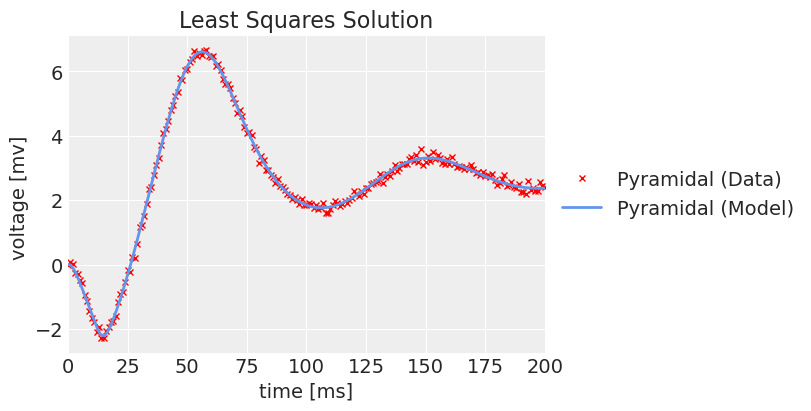

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_data(ax, lw=0);
plot_model(ax, xs_lse, title="Least Squares Solution");

Looks right.  If we didn't care about uncertainty, then we would be done.  But we do care about uncertainty, so let's move on to Bayesian inference.  

## PyMC Model Specification for Gradient-Free Bayesian Inference

Like other Numpy or Scipy-based functions, the `scipy.integrate.odeint` function cannot be used directly in a PyMC model because PyMC needs to know the variable input and output types to compile.  Therefore, we use a Pytensor wrapper to give the variable types to PyMC.  Then the function can be used in PyMC in conjunction with gradient-free samplers.   

### Convert Python Function to a Pytensor Operator using @as_op decorator
We tell PyMC the input variable types and the output variable types using the `@as_op` decorator.  `odeint` returns Numpy arrays, but we tell PyMC that they are Pytensor double float tensors for this purpose.  

In [30]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=DCM_ERPmodel, y0=x_init, t=ts, args=(theta,))

### PyMC Model

 we place Gamma prior on all parameters, and we run the chain at the tail of prior.

In [31]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)

In [32]:
prior_specs = dict(shape=shape, rate=rate)

Initializing at the tail of prior

In [33]:
with pm.Model() as prior_model:
    # Priors
    g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
    g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
    g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
    g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
    delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
    tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
    h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
    tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
    h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
    u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])

In [34]:
n_=100

In [35]:
with prior_model:
        prior_predict= pm.sample_prior_predictive(n_)

Sampling: [delta, g_1, g_2, g_3, g_4, h_e, h_i, tau_e, tau_i, u]


In [36]:
def tails_percentile(my_var_names, prior_predictions, thr):
    tails_xth_percentile = {}
    for key, value in prior_predictions.items():
        if key in my_var_names:
            sorted_values = np.sort(value)[0, :] if value.shape[0] == 1 else np.sort(value)
            top_xth_percentile = sorted_values[int(0.05 * len(sorted_values))]
            tails_xth_percentile[key] = np.array(top_xth_percentile)
    return tails_xth_percentile

In [37]:
tails_5th_percentile=tails_percentile(my_var_names, prior_predict.prior, 0.05)    
tails_5th_percentile

{'delta': array(8.28233042),
 'g_1': array(0.34620747),
 'g_2': array(0.42352853),
 'g_3': array(0.10476462),
 'g_4': array(0.15555497),
 'h_e': array(1.08961554),
 'h_i': array(13.11441501),
 'tau_e': array(3.77407338),
 'tau_i': array(5.6631745),
 'u': array(1.9736873)}

In [38]:
with pm.Model() as model:
    # Priors
    g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
    g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
    g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
    g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
    delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
    tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
    h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
    tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
    h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
    u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])
    
    params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]
    
    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(pm.math.stack(params_samples))
    xpy_hat=ode_solution[:, 8][::ds][:, np.newaxis]
    
    # Likelihood
    pm.Normal("xpy_obs", mu=xpy_hat, sigma=sigma_true, observed=data[["pyramidal"]].values)

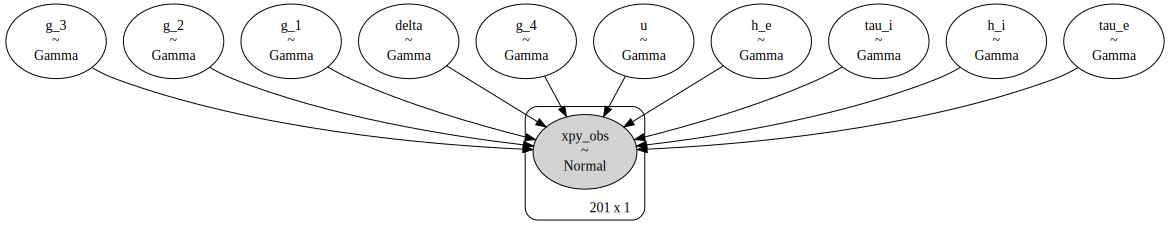

In [39]:
pm.model_to_graphviz(model=model)

In [40]:
model.debug()

point={'g_1_log__': array(-0.60733652), 'g_2_log__': array(-0.51416453), 'g_3_log__': array(-1.92620557), 'g_4_log__': array(-1.53530494), 'delta_log__': array(2.45648145), 'tau_i_log__': array(2.07619879), 'h_i_log__': array(2.97667177), 'tau_e_log__': array(1.66453197), 'h_e_log__': array(0.52585216), 'u_log__': array(1.12187298)}

No problems found


### Plotting Functions
A couple of plotting functions that we will reuse below.  

In [41]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']
    row = trace_df.iloc[row_idx, :][cols].values
    ts = np.arange(t0, tend + dt, dt)
    theta = row
    xs= odeint(DCM_ERPmodel, x_init, t=ts, args=(theta,))
    plot_model(ax, xs, ts=ts, lw=lw, alpha=alpha);

In [42]:
def plot_inference(ax,trace, num_samples=20, 
                   title="Evoked Related Potential (ERP)", plot_model_kwargs=dict(lw=1, alpha=0.2),):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

In [43]:
def plot_joint_post(ax, trace, var_name1, var_name2, my_var_names, theta_true, alpha=1, lw=3, title="Joint Posterior"):
    var_index1 = my_var_names.index(var_name1)
    var_index2 = my_var_names.index(var_name2)
    ax.plot(trace.posterior[f"{var_name1}"].values, trace.posterior[f"{var_name2}"].values, '.',  markersize=4,color='b')
    ax.plot(theta_true[var_index1], theta_true[var_index2], 'o', color='red', markersize=10)  # Add circle for true values
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(f"{var_name1}", fontsize=14)
    ax.set_ylabel(f"{var_name2}", fontsize=14)
    return ax

In [44]:
def plot_trace(trace, my_var_names, theta_true, sampler):
    axes = az.plot_trace(trace,var_names=my_var_names,compact=True, kind="trace",
        backend_kwargs={"figsize": (8, 10), "layout": "constrained"},)

    for ax, true_val in zip(axes[:, 0], theta_true):
        ax.axvline(x=true_val, color='red', linestyle='--')
    for ax, true_val in zip(axes[:, 1], theta_true):
        ax.axhline(y=true_val, color='red', linestyle='--')
        plt.tight_layout();
        
    plt.suptitle(f"Trace Plot {sampler}");
    return axes     


## Gradient-Free Sampler Options
Having good gradient free samplers can open up the models that can be fit within PyMC.  There are five options for gradient-free samplers in PyMC that are applicable to this problem: 
* `Slice` - the default gradient-free sampler
* `DEMetropolisZ` - a differential evolution Metropolis sampler that uses the past to inform sampling jumps
* `DEMetropolis` - a differential evolution Metropolis sampler
* `Metropolis` - the vanilla Metropolis sampler
* `SMC` - Sequential Monte Carlo  

Let's give them a shot.

A few notes on running these inferences.  For each sampler, the number of tuning steps and draws have been reduced to run the inference in a reasonable amount of time (on the order of minutes).  This is not a sufficient number of draws to get a good inferences, in some cases, but it works for demonstration purposes.  In addition, multicore processing was not working for the Pytensor op function on all machines, so inference is performed on one core.         

In [45]:
tune, draws, n_chains = 200, 200, 4

In [46]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]

### Slice Sampler

 Slice Sampler is so slow and its compiling takes a lot of time. so we just run it with a few samples

In [47]:
sampler = "Slice Sampler"

start_time = time.time()
with model:
    trace_slice = pm.sample(step=[pm.Slice(vars_list)], tune=tune, draws=draws, chains=n_chains, 
                            initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names}
                           ) 
crudetime_slice=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_slice)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [g_1]
>Slice: [g_2]
>Slice: [g_3]
>Slice: [g_4]
>Slice: [delta]
>Slice: [tau_i]
>Slice: [h_i]
>Slice: [tau_e]
>Slice: [h_e]
>Slice: [u]


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1231252951540D-07   r2 =  0.7909452697174D-24
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1231252951545D-07   r2 =  0.5845935675734D-24
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1231252951549D-07   r2 =  0.5025830436016D-24
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1231252951552D-07   r2 =  0.4659987287047D-24
 lsoda--  warning..internal t (=r1) 

/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 64 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


---running took: 76.45389676094055 seconds ---


In [48]:
trace = trace_slice
az.summary(trace)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
delta  15.933   2.287  12.757   19.881      1.093    0.831       5.0   
g_1     0.398   0.148   0.137    0.669      0.050    0.037       8.0   
g_2     1.614   0.662   0.829    2.351      0.324    0.247       5.0   
g_3     0.100   0.103   0.004    0.266      0.051    0.039       4.0   
g_4     0.563   0.404   0.152    1.326      0.196    0.150       5.0   
h_e     1.033   0.381   0.637    1.614      0.186    0.142       5.0   
h_i    80.053  41.859  33.910  139.489     20.464   15.619       5.0   
tau_e   6.176   0.819   4.926    7.454      0.395    0.301       5.0   
tau_i   5.738   0.107   5.534    5.907      0.042    0.032       7.0   
u       3.491   0.648   2.240    4.607      0.222    0.162       9.0   

       ess_tail  r_hat  
delta      26.0   3.10  
g_1        30.0   1.44  
g_2        11.0   3.55  
g_3        12.0   3.93  
g_4        12.0   3.47  
h_e        11.0   2.69  
h_i        12.0   3.58  
tau_e      22.0   3.17  
tau_i      53.0   1.65  
u          63.0   1.40

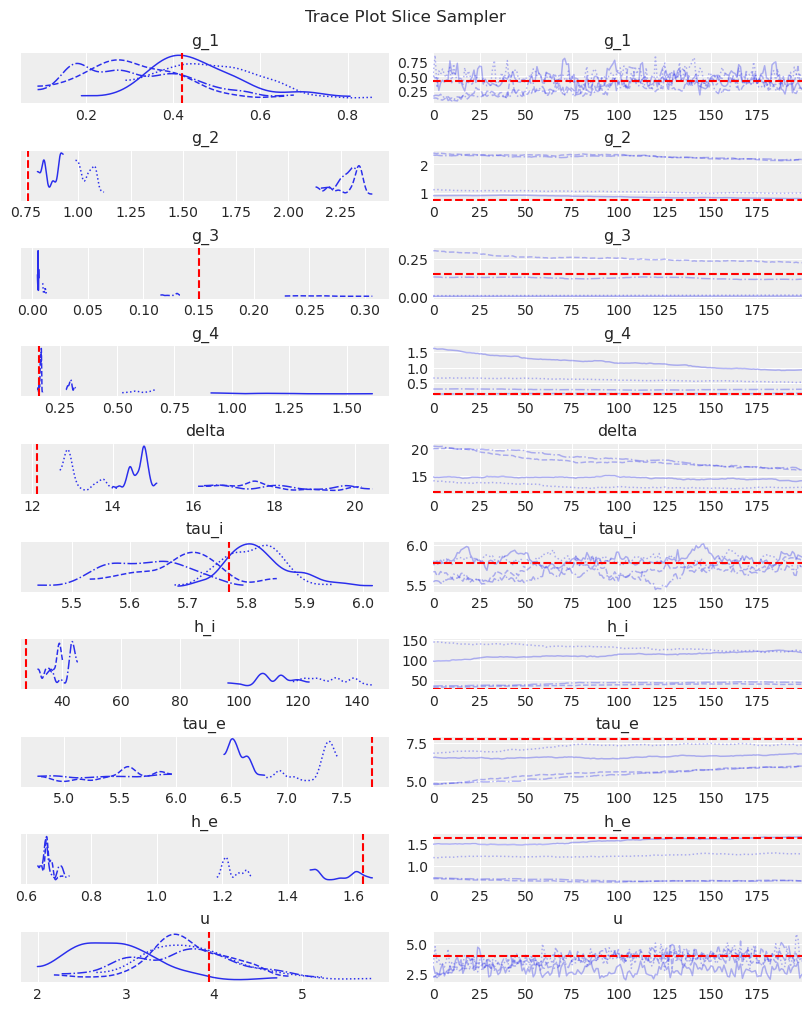

In [49]:
plot_trace(trace, my_var_names, theta_true, sampler);

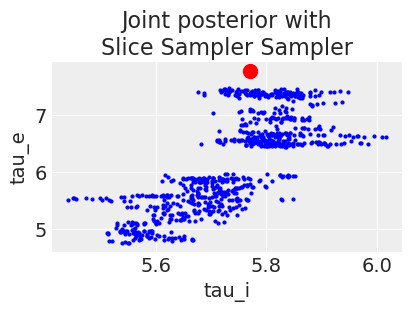

In [50]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

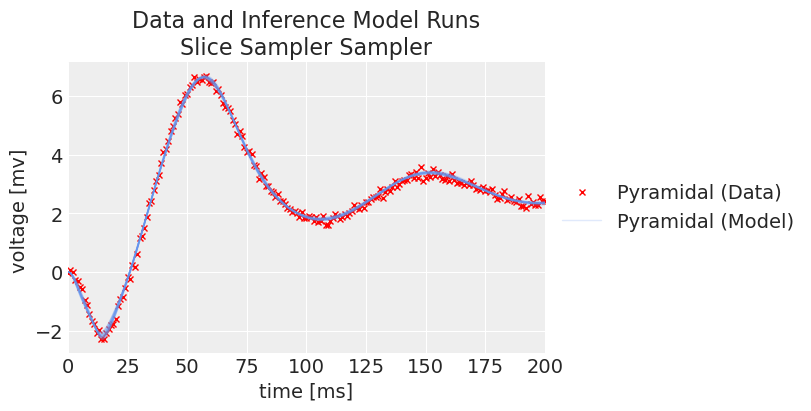

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [52]:
rmse_params_slice, rmse_fit_slice  =rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_params_slice),
print ('RMSE to true observation', rmse_fit_slice)

RMSE to true parameters 2970.0137362488445
RMSE to true observation 14535.974481198158


**Notes:**  
The Slice sampler was so slow and resulted in a low effective sample size. Moreover, the sampler cannot converge for this problem, hence the fit deviates from observation!  

### Metropolis Sampler

In [53]:
sampler = "Metropolis"

start_time = time.time()
with model:
    trace_M = pm.sample(step=[pm.Metropolis(vars_list)], tune=tune, draws=draws, chains=n_chains,
                       initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names}
                       )
crudetime_M=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_M)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [g_1]
>Metropolis: [g_2]
>Metropolis: [g_3]
>Metropolis: [g_4]
>Metropolis: [delta]
>Metropolis: [tau_i]
>Metropolis: [h_i]
>Metropolis: [tau_e]
>Metropolis: [h_e]
>Metropolis: [u]


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 15 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See htt

---running took: 25.274076223373413 seconds ---


In [54]:
trace = trace_M
az.summary(trace)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
delta  11.716   4.661   5.547   18.136      2.283    1.743       4.0   
g_1     0.298   0.283   0.010    0.720      0.131    0.099       6.0   
g_2     0.865   0.371   0.504    1.387      0.182    0.139       4.0   
g_3     0.175   0.065   0.127    0.287      0.032    0.024       4.0   
g_4     0.570   0.426   0.127    1.264      0.209    0.159       4.0   
h_e     1.665   0.326   1.312    2.038      0.160    0.122       4.0   
h_i    18.174  14.913   4.620   43.327      7.305    5.577       4.0   
tau_e   9.648   4.108   4.951   15.202      2.012    1.536       4.0   
tau_i   5.182   1.737   2.277    6.679      0.851    0.649       4.0   
u       5.055   5.710   0.848   15.225      2.761    2.104       4.0   

       ess_tail  r_hat  
delta       5.0   8.25  
g_1        16.0   1.95  
g_2         4.0   6.65  
g_3         4.0   4.03  
g_4         4.0  22.32  
h_e         7.0   4.75  
h_i         5.0   4.92  
tau_e      11.0   6.83  
tau_i      11.0   4.67  
u           7.0   3.84

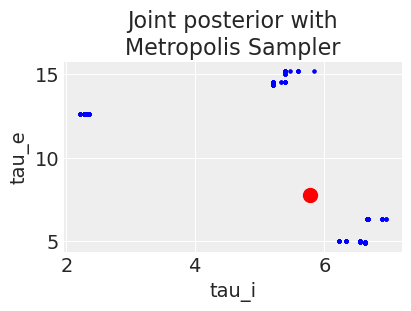

In [55]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no 

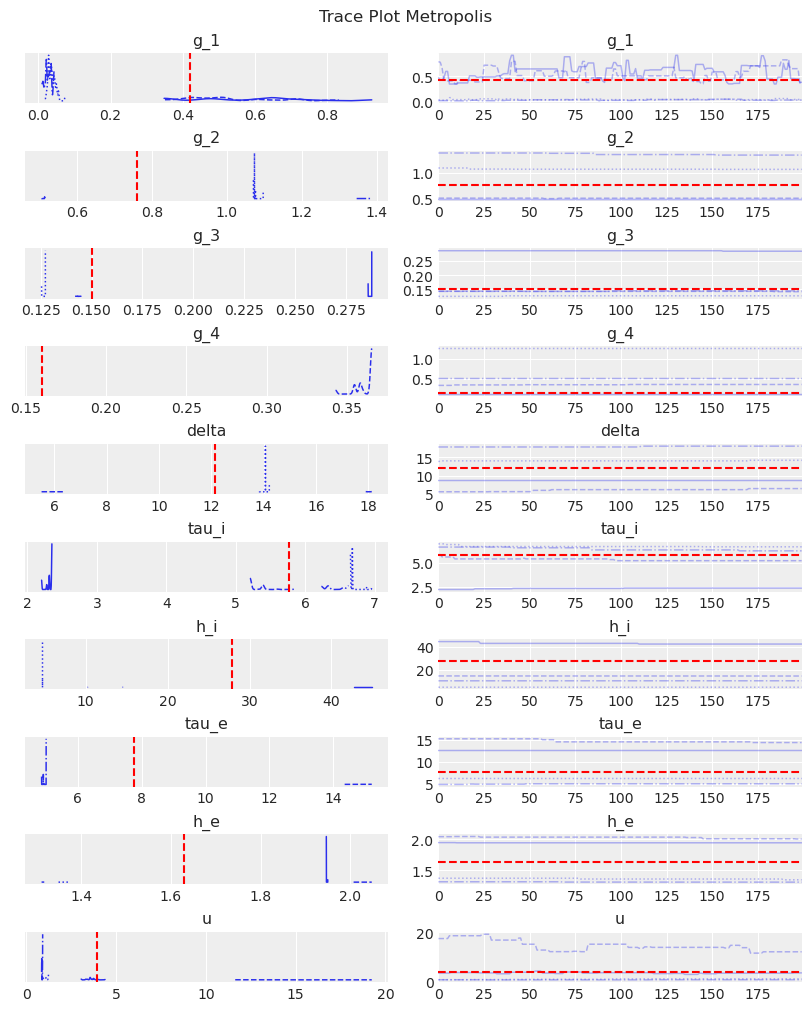

In [56]:
plot_trace(trace, my_var_names, theta_true, sampler);

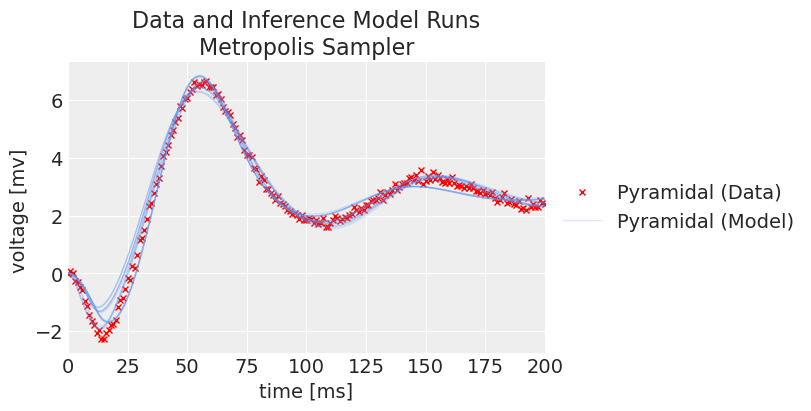

In [57]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [58]:
rmse_params_M, rmse_fit_M=rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_params_M),
print ('RMSE to true observation', rmse_fit_M)

RMSE to true parameters 52.570135872844155
RMSE to true observation 5077.122343263835


**Notes:**  
The old-school Metropolis sampler is not also reliable. Not recommended.   

### DE MetropolisZ Sampler

In [59]:
sampler = "DE MetropolisZ"

start_time = time.time()
with model:
   trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=n_chains,
                            initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names}
                         ) 
crudetime_DEMZ=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_DEMZ)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than

---running took: 6.815013647079468 seconds ---


In [60]:
trace = trace_DEMZ
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  19.443  5.337  10.404   24.992      2.557    1.945       5.0      12.0   
g_1     0.473  0.138   0.298    0.672      0.067    0.051       5.0      11.0   
g_2     0.685  0.234   0.434    1.054      0.111    0.085       5.0      12.0   
g_3     0.096  0.041   0.063    0.178      0.020    0.015       5.0      11.0   
g_4     0.128  0.047   0.063    0.194      0.023    0.017       5.0      11.0   
h_e     1.958  0.439   1.276    2.462      0.205    0.155       5.0      12.0   
h_i    15.735  2.679  11.482   20.241      1.285    0.977       5.0      11.0   
tau_e   5.813  0.647   4.677    6.912      0.239    0.176       7.0      11.0   
tau_i   6.020  1.306   3.781    7.896      0.618    0.472       5.0      21.0   
u       2.371  0.847   1.461    3.793      0.408    0.311       5.0      11.0   

       r_hat  
delta   2.99  
g_1     3.30  
g_2     2.76  
g_3     3.56  
g_4     3.70  
h_e     2.72  
h_i     3.48  
tau_e   1.56  
tau_i   2.99  
u       3.27

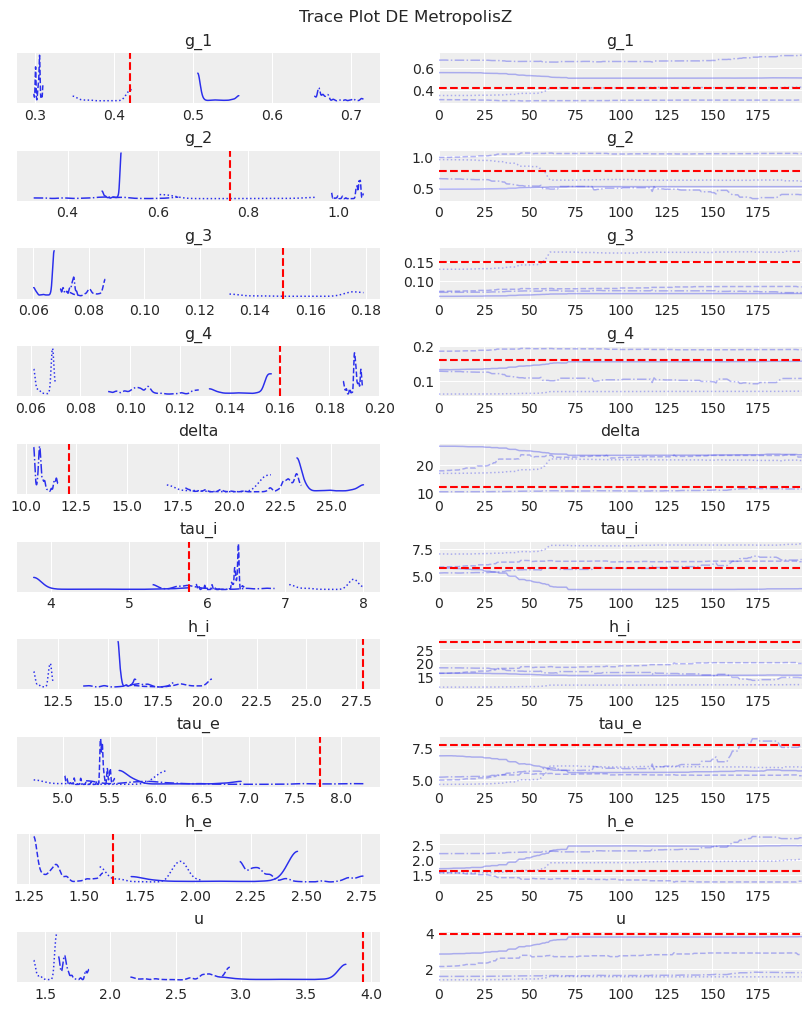

In [61]:
plot_trace(trace, my_var_names, theta_true, sampler);

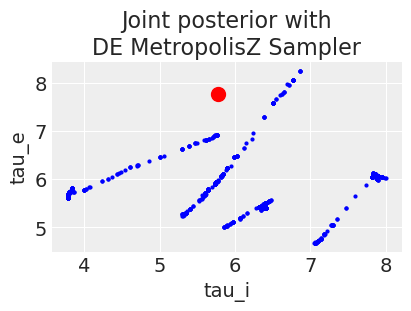

In [62]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

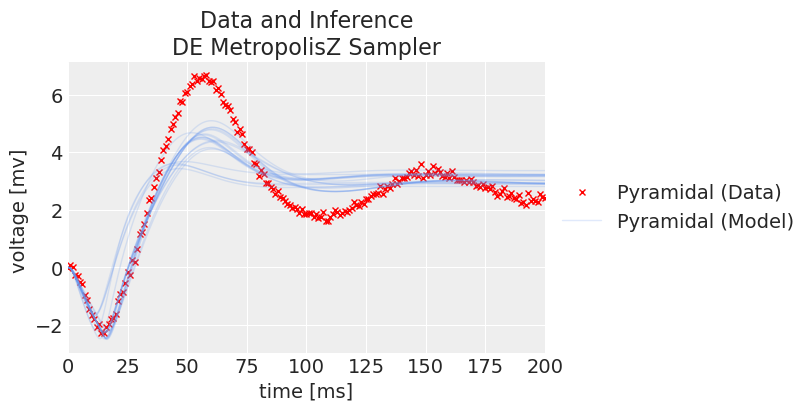

In [63]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference\n{sampler} Sampler")

In [64]:
rmse_fit_DEMZ, rmse_params_DEMZ =rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_fit_DEMZ),
print ('RMSE to true observation', rmse_params_DEMZ)

RMSE to true parameters 62.03254583662966
RMSE to true observation 140.16906596165887


**Notes:**  
DEMetropolisZ is much quicker than the Slice and Metropolis samplers and therefore had a higher ESS per minute spent sampling.  But there is no convergence hence the estimated parameters and the fit deviates from true values. 

### DEMetropolis Sampler

In these experiments, DEMetropolis sampler was not accepting `tune` and requiring `chains` to be at least 11. We set draws at 5000, lower number like 3000 produce bad mixing. 

In [65]:
sampler = "DEMetropolis"

start_time = time.time()
with model:
    trace_DEM = pm.sample(step=[pm.DEMetropolis(vars_list)],  draws=4000, chains=12,
                          initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names}
                         )
crudetime_DEM=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_DEM)

Population sampling (12 chains)
DEMetropolis: [g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overfl

---running took: 110.060631275177 seconds ---


In [66]:
trace = trace_DEM
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  12.449  0.888  11.756   13.542      0.219    0.158      71.0      16.0   
g_1     0.530  0.117   0.309    0.748      0.004    0.003     628.0     372.0   
g_2     0.654  0.084   0.520    0.825      0.011    0.008      86.0      27.0   
g_3     0.140  0.019   0.106    0.178      0.001    0.000     839.0    1252.0   
g_4     0.215  0.032   0.154    0.275      0.002    0.002     415.0     175.0   
h_e     1.940  0.231   1.541    2.360      0.025    0.019     144.0      56.0   
h_i    19.606  3.191  14.219   25.892      0.204    0.169     393.0     117.0   
tau_e   7.703  0.887   7.089    8.056      0.228    0.164      71.0      16.0   
tau_i   5.689  0.351   5.603    5.899      0.091    0.066      64.0      16.0   
u       3.419  0.870   2.172    4.656      0.184    0.143      70.0      18.0   

       r_hat  
delta   1.12  
g_1     1.02  
g_2     1.09  
g_3     1.02  
g_4     1.04  
h_e     1.06  
h_i     1.04  
tau_e   1.12  
tau_i   1.12  
u       1.12

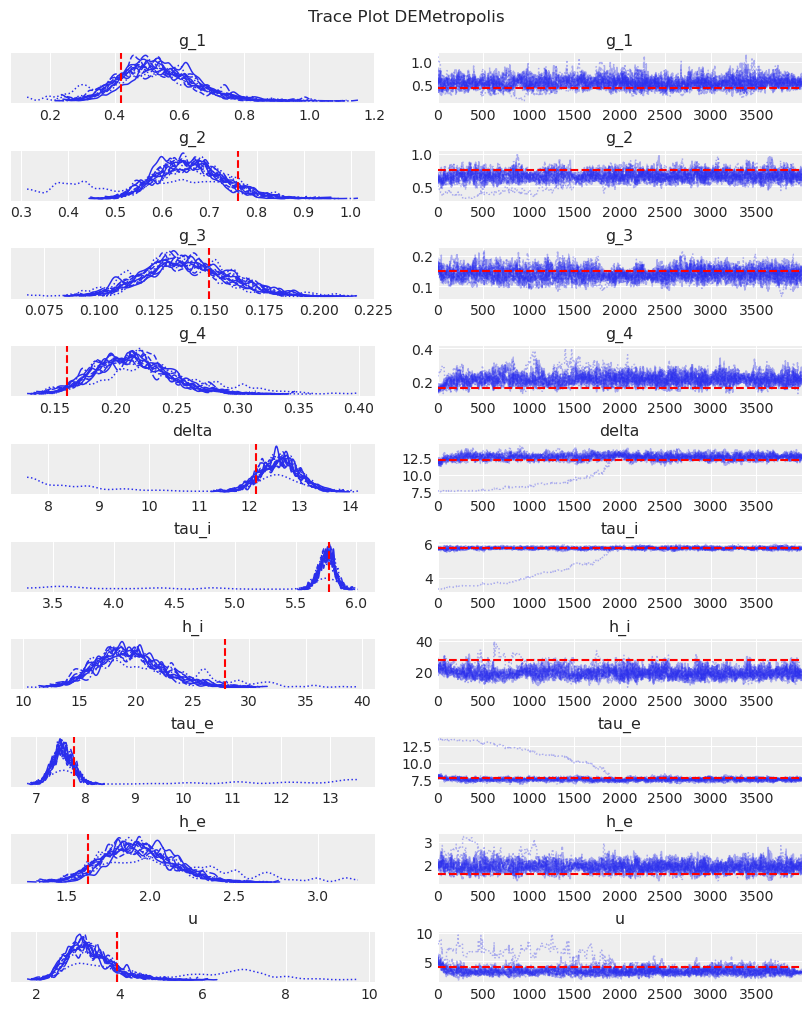

In [67]:
plot_trace(trace, my_var_names, theta_true, sampler);

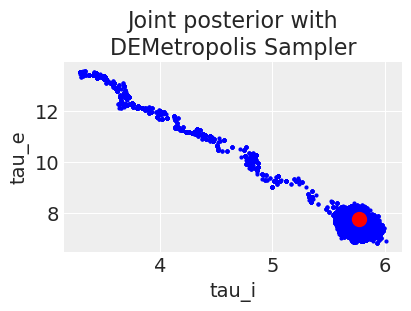

In [68]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

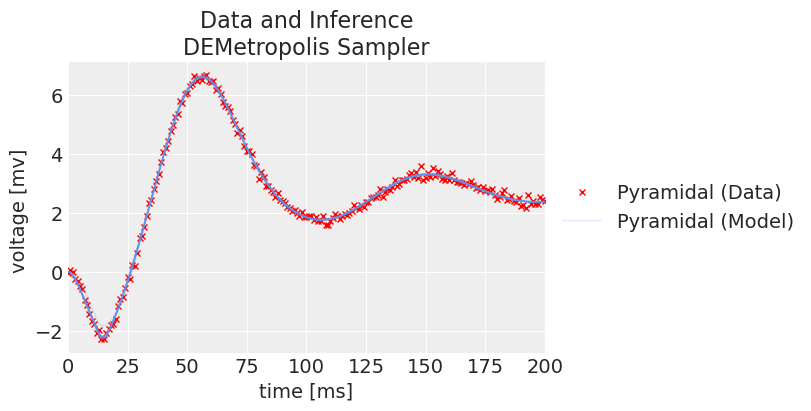

In [69]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference\n{sampler} Sampler")

In [70]:
rmse_params_DEM, rmse_fit_DEM =rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_params_DEM),
print ('RMSE to true observation', rmse_fit_DEM)

RMSE to true parameters 68.15102681486316
RMSE to true observation 4.339916300805008


**Notes:**  
Despite the high number of EES by fast sampling over large iterations, this is also not an appropriate samlper for our model.

### SMC Sampler

The Sequential Monte Carlo (SMC) sampler can be used to sample a regular Bayesian model or to run model without a likelihood (Aproximate Bayesian Computation). Let's try first with a regular model,

#### SMC with a Likelihood Function

SMC has no initialized strategy!

In [71]:
sampler = "SMC with Likelihood"

start_time = time.time()
with model:
    trace_SMC_like = pm.sample_smc(draws=draws, chains=n_chains)
crudetime_SMC_like=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_SMC_like)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


---running took: 15.811017274856567 seconds ---.00% [100/100 00:00<?  Stage: 14 Beta: 1.000]


In [72]:
trace = trace_SMC_like
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  12.628  0.373  11.981   13.341      0.013    0.009     872.0     786.0   
g_1     0.524  0.120   0.316    0.737      0.005    0.003     676.0     624.0   
g_2     0.672  0.075   0.531    0.800      0.003    0.002     878.0     777.0   
g_3     0.142  0.020   0.108    0.178      0.001    0.001     742.0     735.0   
g_4     0.213  0.032   0.153    0.268      0.001    0.001     738.0     660.0   
h_e     1.896  0.207   1.559    2.315      0.007    0.005     867.0     857.0   
h_i    19.579  3.149  13.704   25.354      0.121    0.086     678.0     680.0   
tau_e   7.523  0.202   7.147    7.884      0.007    0.005     912.0     770.0   
tau_i   5.760  0.067   5.640    5.886      0.002    0.002     878.0     733.0   
u       3.280  0.562   2.301    4.345      0.020    0.014     766.0     814.0   

       r_hat  
delta   1.00  
g_1     1.01  
g_2     1.00  
g_3     1.00  
g_4     1.00  
h_e     1.00  
h_i     1.00  
tau_e   1.00  
tau_i   1.00  
u       1.00

In [73]:
trace.sample_stats._t_sampling

15.580547094345093

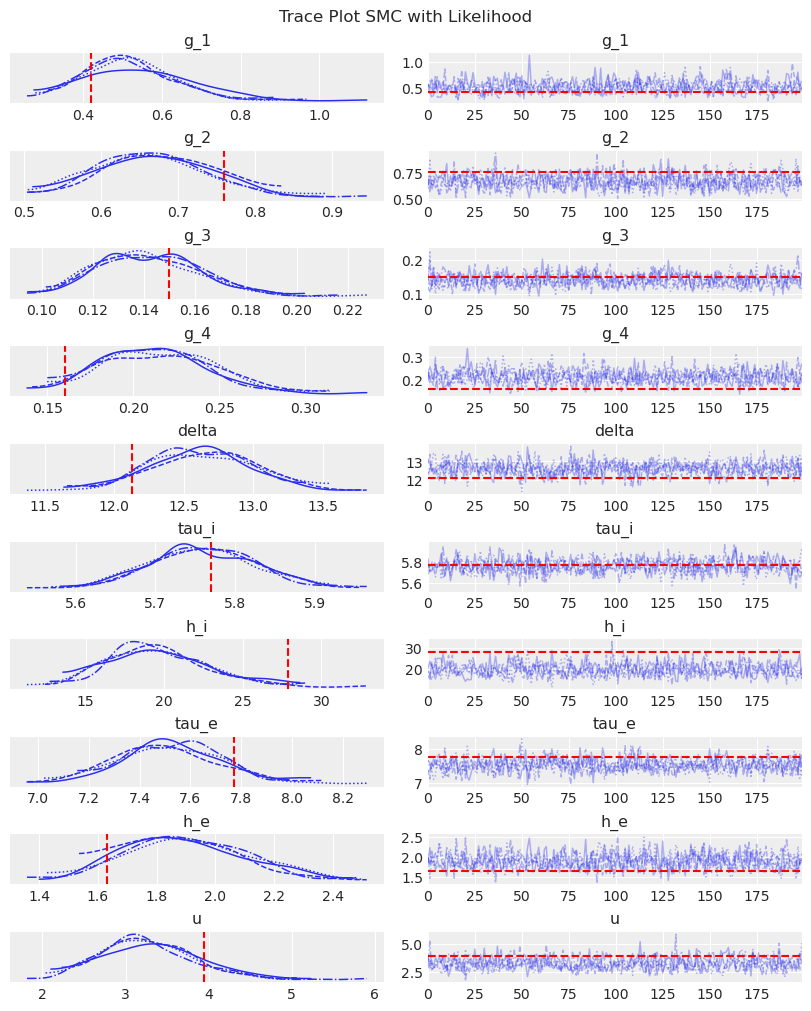

In [74]:
plot_trace(trace, my_var_names, theta_true, sampler);

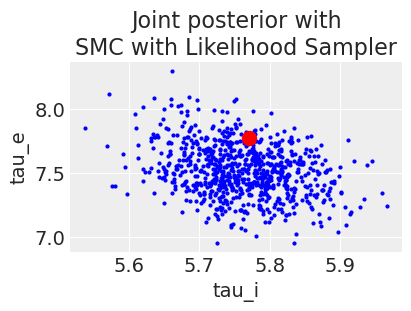

In [75]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

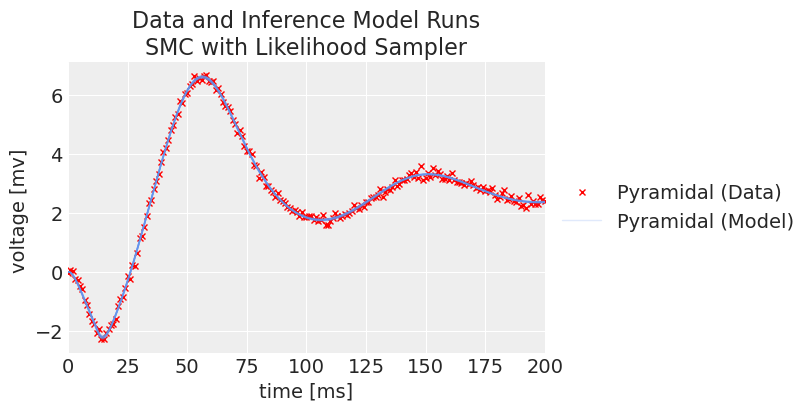

In [76]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [77]:
rmse_fit_SMC_like, rmse_params_SMC_like=rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_fit_SMC_like),
print ('RMSE to true observation', rmse_params_SMC_like)

RMSE to true parameters 70.27184226292297
RMSE to true observation 2.954715813402654


**Notes:**  
The SMC algorithm finds different modes, and its convergence is better than previus samplers, but still the fit deviates from the observation.  

#### SMC Using `pm.Simulator` Epsilon=1

As outlined in the SMC tutorial on PyMC.io, the SMC sampler can be used for Aproximate Bayesian Computation, i.e. we can use a `pm.Simulator` instead of a explicit likelihood.  Here is a rewrite of the PyMC - odeint model for SMC-ABC.

The simulator function needs to have the correct signature (e.g., accept an rng argument first).  

In [78]:
def simulator_forward_model(rng,  g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u, size=None):
    theta = g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u 
    mu=odeint(func=DCM_ERPmodel, y0=x_init, t=ts, args=(theta,))[:,8][::ds].reshape(-1, 1)
    return rng.normal(mu, sigma_true)

Here is the model with the simulator function. Instead of a explicit likelihood function, the simulator uses distance metric (defaults to `gaussian`) between the simulated and observed values. When using a simulator we also need to specify epsilon, that is a tolerance value for the discrepancy between simulated and observed values. If epsilon is too low, SMC will not be able to move away from the initial values or a few values. We can easily see this with `az.plot_trace`. If epsilon is too high, the posterior will virtually be the prior. So

In [79]:
with pm.Model() as model:
    # Priors
    g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
    g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
    g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
    g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
    delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
    tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
    h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
    tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
    h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
    u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])
    
    #sigma = pm.HalfNormal("sigma", 10)
    
    # ode_solution
    pm.Simulator(
        "xpy_obs",
        simulator_forward_model,
        params=(g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u),
        epsilon=1,
        observed=data[["pyramidal"]].values,)

Inference.  Note the `progressbar` was throwing an error so it is turned off.  

In [80]:
sampler = "SMC_epsilon=1"

start_time = time.time()
with model:
    trace_SMC_e1 = pm.sample_smc(draws=draws, progressbar=False, chains=n_chains)
crudetime_SMC_e1=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_SMC_e1)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


    ---running took: 14.696001529693604 seconds ---


In [81]:
trace = trace_SMC_e1
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  13.884  1.446  11.289   16.519      0.052    0.037     772.0     862.0   
g_1     0.538  0.121   0.328    0.766      0.004    0.003     749.0     713.0   
g_2     0.695  0.082   0.549    0.847      0.003    0.002     870.0     772.0   
g_3     0.141  0.023   0.098    0.182      0.001    0.001     886.0     763.0   
g_4     0.209  0.031   0.144    0.261      0.001    0.001     860.0     805.0   
h_e     1.956  0.233   1.500    2.376      0.008    0.005     908.0     748.0   
h_i    18.578  3.187  13.330   25.100      0.115    0.081     772.0     811.0   
tau_e   6.824  0.618   5.661    7.956      0.022    0.016     773.0     764.0   
tau_i   6.216  0.531   5.331    7.211      0.019    0.014     765.0     753.0   
u       3.090  0.597   1.990    4.135      0.020    0.014     852.0     770.0   

       r_hat  
delta   1.00  
g_1     1.00  
g_2     1.00  
g_3     1.00  
g_4     1.01  
h_e     1.00  
h_i     1.00  
tau_e   1.00  
tau_i   1.01  
u       1.00

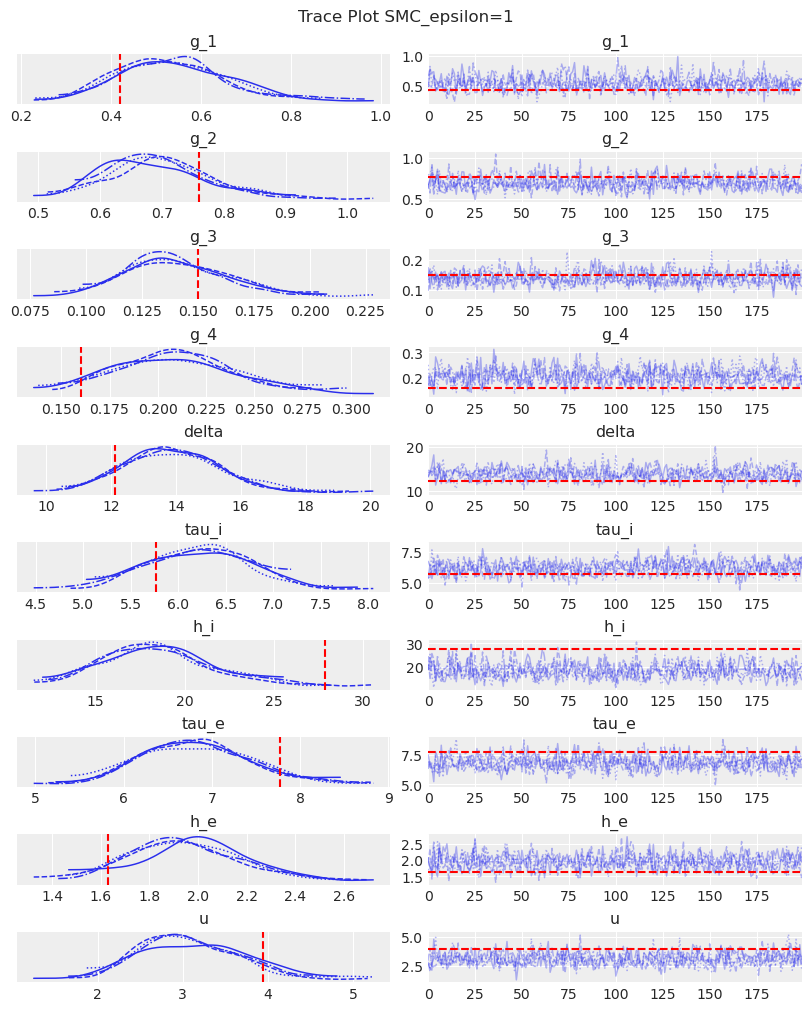

In [82]:
plot_trace(trace, my_var_names, theta_true, sampler);

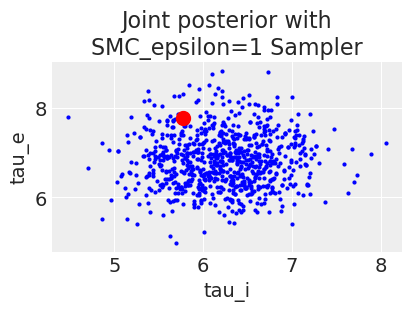

In [83]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

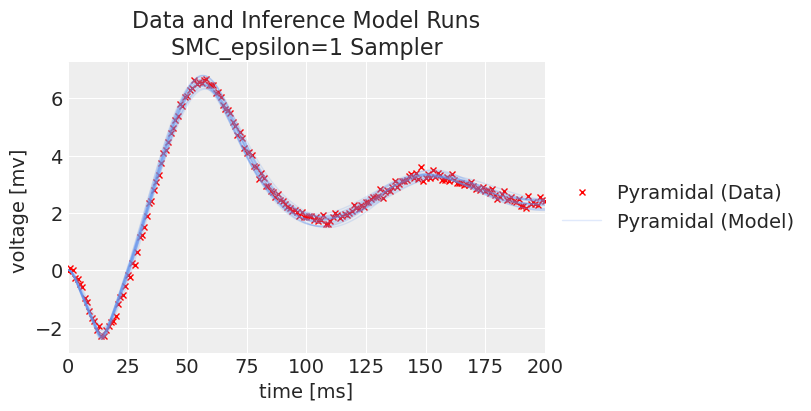

In [84]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [85]:
rmse_params_SMC_e1, rmse_fit_SMC_e1=rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_params_SMC_e1),
print ('RMSE to true observation', rmse_fit_SMC_e1)

RMSE to true parameters 71.73959074354326
RMSE to true observation 4.6140020617785655


**Notes:**  
Noe we can see that by tunning the Epsilon parameters the chains convrged to same mode, and leads to a decent fit.

In [86]:
with pm.Model() as model:
   # Priors
    g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
    g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
    g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
    g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
    delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
    tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
    h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
    tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
    h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
    u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])
    
    #sigma = pm.HalfNormal("sigma", 10)
    
    # ode_solution
    pm.Simulator(
        "xpy_obs",
        simulator_forward_model,
        params=(g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u),
        epsilon=10,
        observed=data[["pyramidal"]].values, )

In [87]:
sampler = "SMC epsilon=10"

start_time = time.time()
with model:
    trace_SMC_e10 = pm.sample_smc(draws=draws, chains=n_chains )
crudetime_SMC_e10=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_SMC_e10)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/data/base.py:265: UserWarning: More chains (4) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


---running took: 6.2767016887664795 seconds ---


In [88]:
trace = trace_SMC_e10
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  12.570  2.241   8.825   17.136      0.079    0.056     818.0     734.0   
g_1     0.549  0.131   0.327    0.791      0.004    0.003     903.0     626.0   
g_2     0.667  0.105   0.460    0.851      0.004    0.003     836.0     750.0   
g_3     0.138  0.024   0.092    0.182      0.001    0.001     755.0     688.0   
g_4     0.205  0.035   0.142    0.269      0.001    0.001     902.0     771.0   
h_e     1.826  0.308   1.274    2.393      0.011    0.008     833.0     819.0   
h_i    18.170  3.757  11.801   25.434      0.134    0.095     784.0     725.0   
tau_e   5.914  0.823   4.557    7.520      0.030    0.021     750.0     724.0   
tau_i   7.795  1.225   5.767   10.300      0.045    0.032     758.0     815.0   
u       3.073  0.605   2.057    4.233      0.021    0.015     798.0     797.0   

       r_hat  
delta   1.00  
g_1     1.00  
g_2     1.00  
g_3     1.00  
g_4     1.00  
h_e     1.00  
h_i     1.00  
tau_e   1.00  
tau_i   1.01  
u       1.00

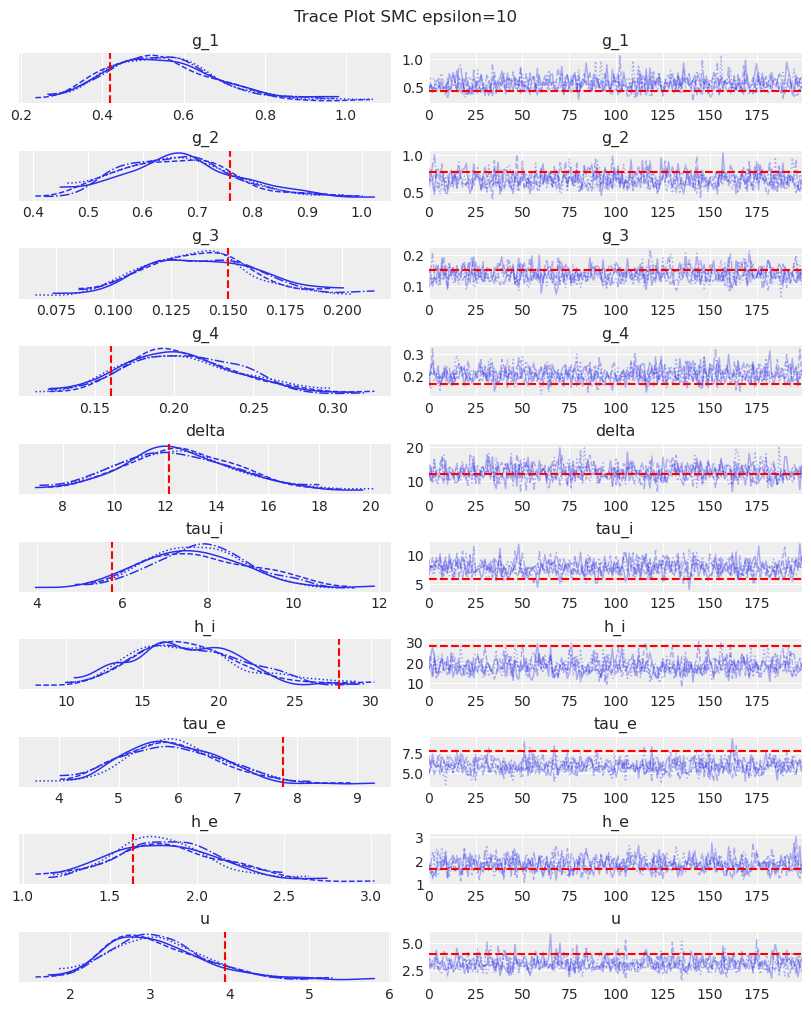

In [89]:
plot_trace(trace, my_var_names, theta_true, sampler);

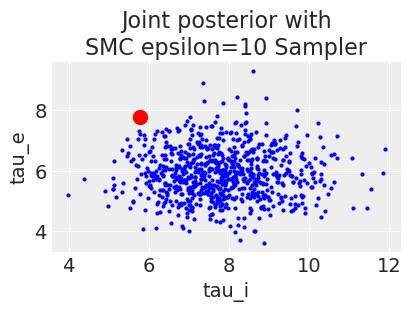

In [90]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

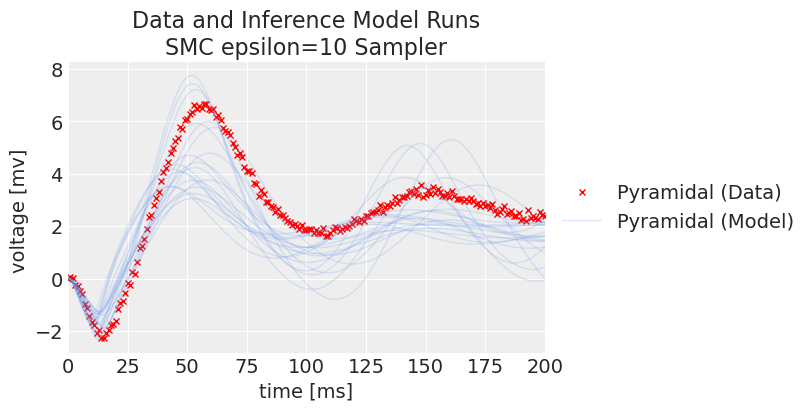

In [91]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [92]:
rmse_params_SMC_e10, rmse_fit_SMC_e10=rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_params_SMC_e10),
print ('RMSE to true observation', rmse_fit_SMC_e10)

RMSE to true parameters 93.91904007888022
RMSE to true observation 169.99483712209621


**Notes:**  
Now that we set a larger value for epsilon we can see that the SMC sampler (plus simulator) provides good results. Choosing a value for epsilon 
will always involve some trial and error. So, what to do in practice? As epsilon is the scale of the distance function. If you don't have any idea of how much error do you expected to get between simulated and observed values then a rule of thumb for picking an initial guess for epsilon is to use a number smaller than the standard deviation of the observed data, how much smaller maybe one order of magnitude or so.

### Posterior Correlations
As an aside, it is worth pointing out that the posterior parameter space is a difficult geometry for sampling, dur no nonlinear relation betwen parameters (eg banna shape between g_3 and g_4).  

/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/pairplot.py:233: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


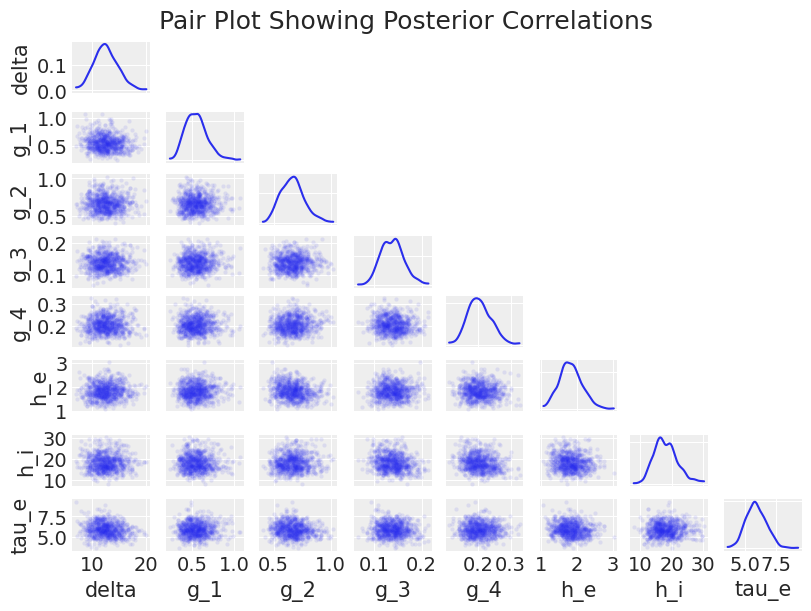

In [93]:
az.plot_pair(trace, figsize=(8, 6), scatter_kwargs=dict(alpha=0.1), marginals=True)
plt.suptitle("Pair Plot Showing Posterior Correlations", size=18);

The major observation here is that the posterior shape is pretty difficult for a sampler to handle, with positive correlations, negative correlations, crecent-shapes, and large variations in scale.  This contributes to the slow sampling (in addition to the computational overhead in solving the ODE thousands of times).  This is also fun to look at for understanding how the model parameters impact each other.       

## Bayesian Inference with Gradients

NUTS, the PyMC default sampler can only be used if gradients are supplied to the sampler.  In this section, we will solve the system of ODEs within PyMC in two different ways that supply the sampler with gradients.  The first is the built-in `pymc.ode.DifferentialEquation` solver, and the second is to forward simulate using `pytensor.scan`, which allows looping.  Note that there may be other better and faster ways to perform Bayesian inference with ODEs using gradients, such as the [sunode](https://sunode.readthedocs.io/en/latest/index.html) project, and [diffrax](https://www.pymc-labs.io/blog-posts/jax-functions-in-pymc-3-quick-examples/), which relies on JAX.

### PyMC ODE Module

`Pymc.ode` uses `scipy.odeint` under the hood to estimate a solution and then estimate the gradient through finite differences. 

The `pymc.ode` API is similar to `scipy.odeint`.  The right-hand-side equations are put in a function and written as if `y` and `p` are vectors, as follows.  (Even when your model has one state and/or one parameter, you should explicitly write `y[0]` and/or `p[0]`.)

In [94]:
# We remove jit to avoid error with Pymc gradient-based samplers
def Sigmodal(x1, x2, delta, c):
    S=(1./(1.+np.exp(c*(x1-(delta*x2)))))-0.5
    return S

In [95]:
def DCM_ERPmodel_pymcode(x, t, p):
    c = constants[0]
    dx0_dt = x[3]
    dx1_dt = x[4]
    dx2_dt = x[5]
    dx3_dt = (1./p[7]) * (p[8] * (p[0] * (Sigmodal(x[8], x[4] - x[5], p[4] , c)) + p[9]) - (x[0] / p[7]) - 2 * x[3])
    dx4_dt = (1./p[7]) * (p[8] * (p[1] * (Sigmodal(x[0], x[3], p[4] , c))) - (x[1] / p[7] ) - 2 * x[4])
    dx5_dt = (1./p[5]) * (p[6] * (p[3] * (Sigmodal(x[6], x[7], p[4] , c))) - (x[2] / p[5] ) - 2 * x[5])
    dx6_dt = x[7]
    dx7_dt = (1./p[7]) * (p[8] * (p[2] * (Sigmodal(x[8], x[4] - x[5], p[4] , c))) - (x[6] / p[7] ) - 2 * x[7])
    dx8_dt = x[4] - x[5]
    return [dx0_dt, dx1_dt, dx2_dt, dx3_dt, dx4_dt, dx5_dt, dx6_dt, dx7_dt, dx8_dt]

`DifferentialEquation` takes as arguments:

* `func`: A function specifying the differential equation (i.e. $f(\mathbf{y},t,\mathbf{p})$),
* `times`: An array of times at which data was observed,
* `n_states`: The dimension of $f(\mathbf{y},t,\mathbf{p})$ (number of output parameters),
* `n_theta`: The dimension of $\mathbf{p}$ (number of input parameters),
* `t0`: Optional time to which the initial condition belongs,  

as follows:

In [96]:
ode_model = DifferentialEquation(
    func=DCM_ERPmodel_pymcode, times=data.ts_obs.values, n_states=9, n_theta=10, t0=data.ts_obs.values[0]
)

Once the ODE is specified, we can use it in our PyMC model.

#### Inference with NUTS
`pymc.ode` is quite slow (an order of hours for just a few samples), so for demonstration purposes, we will only draw a few samples.  

In [97]:
with pm.Model() as model:
    # Priors
    g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
    g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
    g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
    g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
    delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
    tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
    h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
    tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
    h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
    u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])
    
    params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]

    # ode_solution
    ode_solution = ode_model(y0=x_init, theta=params_samples)
    
    # Likelihood
    pm.Normal("xpy_obs", mu=ode_solution[:, 8][::ds], sigma=sigma_true, observed=data[["pyramidal"]].values)

In [98]:
sampler = "NUTS PyMC ODE"

start_time = time.time()
with model:
    trace_nuts_pymc_ode = pm.sample(tune=20, draws=20, chains=1,
                                    initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names},  
                                    nuts_sampler_kwargs={"nuts": {"max_treedepth": 10, "target_accept": 0.8}}   
                                   )
crudetime_nuts_pymc_ode=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_nuts_pymc_ode)

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2000000000000D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2000000000000D+01

/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Sampling 1 chain for 20 tune and 20 draw iterations (20 + 20 draws total) took 18287 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


---running took: 18292.45869398117 seconds ---


In [99]:
trace = trace_nuts_pymc_ode
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 20), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta   1.267  0.306   1.009    1.846      0.163    0.127       8.0      26.0   
g_1     0.242  0.156   0.156    0.551      0.086    0.067       2.0      26.0   
g_2     0.822  0.257   0.613    1.397      0.148    0.116       2.0      20.0   
g_3     0.055  0.040   0.032    0.140      0.021    0.016       7.0      26.0   
g_4     0.182  0.024   0.125    0.203      0.009    0.007       8.0      26.0   
h_e     4.124  0.583   2.988    4.721      0.245    0.183       9.0      26.0   
h_i    15.664  4.259   5.941   17.788      1.450    1.062       4.0      26.0   
tau_e   1.786  0.319   1.197    2.132      0.219    0.183       2.0      20.0   
tau_i   5.306  2.066   1.991    7.224      1.408    1.221       2.0      20.0   
u       2.053  1.043   1.315    3.900      0.633    0.507       2.0      20.0   

       r_hat  
delta    NaN  
g_1      NaN  
g_2      NaN  
g_3      NaN  
g_4      NaN  
h_e      NaN  
h_i      NaN  
tau_e    NaN  
tau_i    NaN  
u        NaN

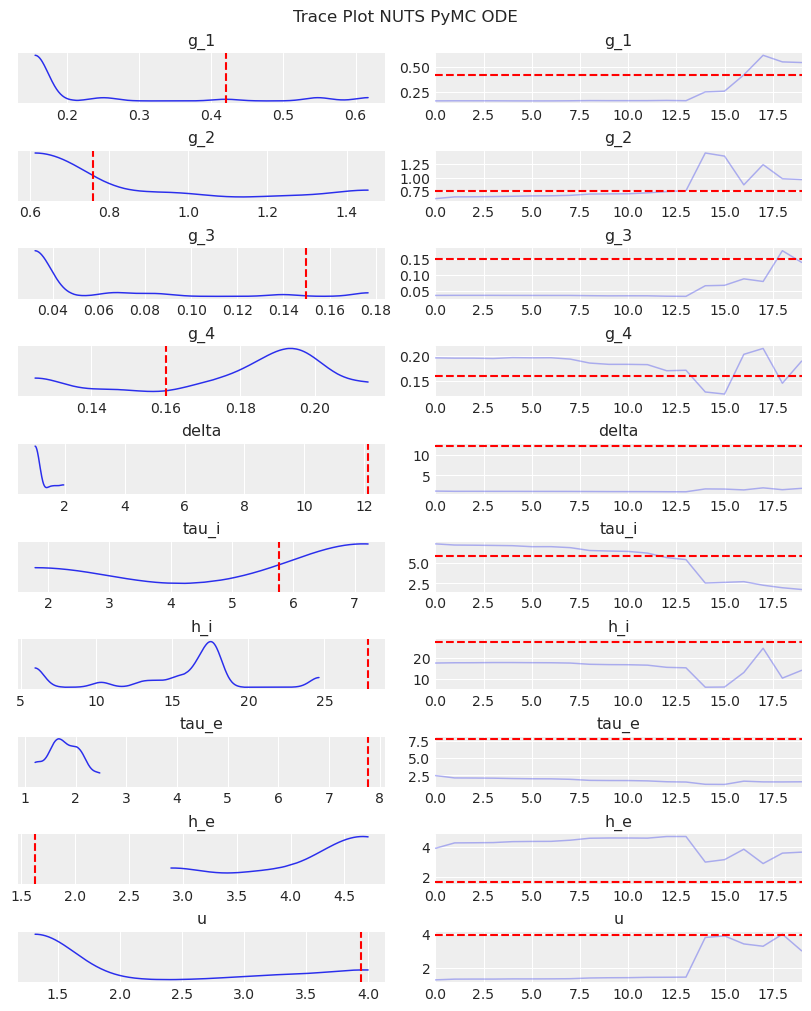

In [100]:
plot_trace(trace, my_var_names, theta_true, sampler);

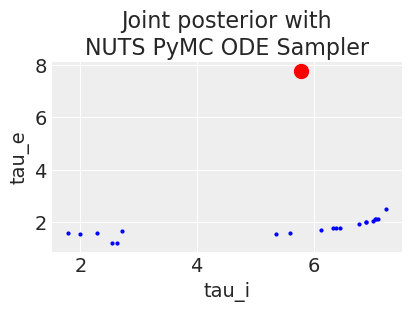

In [101]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

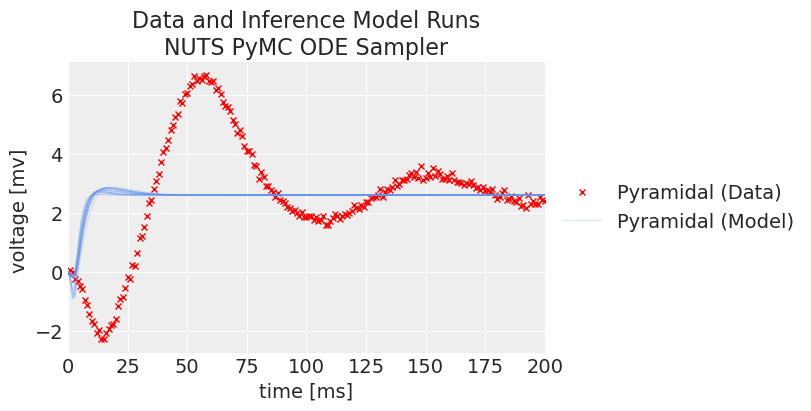

In [102]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [103]:
rmse_params_nuts_pymc_ode, rmse_fit_nuts_pymc_ode=rmse_fit(model, trace, data, theta_true)
print ('RMSE to true parameters', rmse_params_nuts_pymc_ode),
print ('RMSE to true observation', rmse_fit_nuts_pymc_ode)

RMSE to true parameters 846.7710979529762
RMSE to true observation 761.9281199940243


**Notes:**  
This implemenation of NUTS with Pymc ODE module is very very slow.   

### Simulate with Pytensor Scan

Finally, we can write the system of ODEs as a forward simulation solver within PyMC.  The way to write for-loops in PyMC is with `pytensor.scan.`  Gradients are then supplied to the sampler via autodifferentiation.    

First, we should test that the time steps are sufficiently small to get a reasonable estimate.  

#### Check Time Steps

Create a function that accepts different numbers of time steps for testing.  The function also demonstrates how `pytensor.scan` is used.  

In [104]:
dt, n_time

(0.1, 2001)

In [105]:
n_steps=int(n_time)

In [106]:
x_init_float64 = []
for _ in range(n_states):
    x_init_float64.append(np.float64(0.0))

In [107]:
# forward simulation model using scan
def model_scan_simulation(theta):
    # PyMC model
    with pm.Model() as model:
            # Priors (these are static for testing)
            g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u  =theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], theta[6], theta[7], theta[8], theta[9],  

            def ode_update_function(x0, x1, x2, x3, x4, x5, x6, x7, x8, g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ):
                    dx0=x3
                    dx1=x4
                    dx2=x5
                    dx6=x7
                    dx3=(1./tau_e)*(h_e*(g_1*(Sigmodal(x8, x4-x5, delta, c))+u)-(x0/tau_e)-2*x3)
                    dx4=(1./tau_e)*(h_e*(g_2*(Sigmodal(x0, x3, delta, c)))-(x1/tau_e)-2*x4)
                    dx5=(1./tau_i)*(h_i*(g_4*(Sigmodal(x6, x7, delta, c)))-(x2/tau_i)-2*x5)
                    dx7=(1./tau_e)*(h_e*(g_3*(Sigmodal(x8, x4-x5, delta, c)))-(x6/tau_e)-2*x7)
                    dx8=x4-x5

                    x0_new = x0 + dt * dx0 
                    x1_new = x1 + dt * dx1 
                    x2_new = x2 + dt * dx2 
                    x3_new = x3 + dt * dx3 
                    x4_new = x4 + dt * dx4 
                    x5_new = x5 + dt * dx5 
                    x6_new = x6 + dt * dx6 
                    x7_new = x7 + dt * dx7 
                    x8_new = x8 + dt * dx8 

                    return x0_new, x1_new, x2_new, x3_new, x4_new, x5_new, x6_new, x7_new, x8_new
        
            # Pytensor scan looping function
            result, updates = pytensor.scan(
                fn=ode_update_function,  
                outputs_info=x_init_float64,  
                non_sequences=[g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ], 
                n_steps=n_steps, )

            # Put the results together and track the result
            pm.Deterministic("result", pm.math.stack([result[8]], axis=1))

    return model

Run the simulation for various time steps and plot the results.   

In [108]:
model_scan_simulation(theta)

result ~ Deterministic(f())

Sampling: []
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


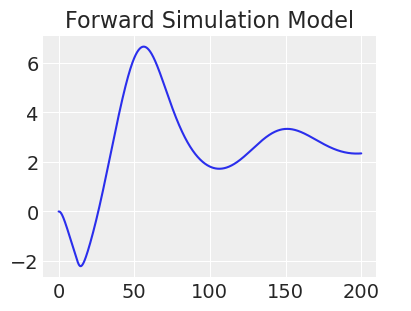

In [109]:
_, ax = plt.subplots(figsize=(4, 3))
model = model_scan_simulation(theta)
with model:
    prior = pm.sample_prior_predictive(1)
    ax.plot(ts, prior.prior.result[0][0].values)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Forward Simulation Model");

#### Inference Using NUTs

Now that we are OK with 100 time steps per year, we write the model with indexing to align the data with the results.  

In [110]:
def model_scan_inference(theta):

    # PyMC model
    with pm.Model() as model:
        # Priors
        g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
        g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
        g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
        g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
        delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
        tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
        h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
        tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
        h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
        u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])

        def ode_update_function(x0, x1, x2, x3, x4, x5, x6, x7, x8, g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ):

                    dx0=x3
                    dx1=x4
                    dx2=x5
                    dx6=x7
                    dx3=(1./tau_e)*(h_e*(g_1*(Sigmodal(x8, x4-x5, delta, c))+u)-(x0/tau_e)-2*x3)
                    dx4=(1./tau_e)*(h_e*(g_2*(Sigmodal(x0, x3, delta, c)))-(x1/tau_e)-2*x4)
                    dx5=(1./tau_i)*(h_i*(g_4*(Sigmodal(x6, x7, delta, c)))-(x2/tau_i)-2*x5)
                    dx7=(1./tau_e)*(h_e*(g_3*(Sigmodal(x8, x4-x5, delta, c)))-(x6/tau_e)-2*x7)
                    dx8=x4-x5

                    x0_new = x0 + dt * dx0 
                    x1_new = x1 + dt * dx1 
                    x2_new = x2 + dt * dx2 
                    x3_new = x3 + dt * dx3 
                    x4_new = x4 + dt * dx4 
                    x5_new = x5 + dt * dx5 
                    x6_new = x6 + dt * dx6 
                    x7_new = x7 + dt * dx7 
                    x8_new = x8 + dt * dx8 

                    return x0_new, x1_new, x2_new, x3_new, x4_new, x5_new, x6_new, x7_new, x8_new
                
                
        result, updates = pytensor.scan(
                fn=ode_update_function,  
                outputs_info=x_init_float64,  
                non_sequences=[g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ],  
                n_steps=n_steps, )

        final_result = pm.math.stack([result[8]], axis=1)
        
        xpy_hat=final_result[::ds]

        # Likelihood function
        pm.Normal("xpy_obs", mu=xpy_hat, sigma=sigma_true, observed=data[["pyramidal"]].values)
    return model

### NUTS Pytensor Scan Pymc

This is also quite slow, so we will just pull a few samples for demonstration purposes.  

In [111]:
model = model_scan_inference(theta)
sampler = "NUTS Pytensor Scan Pymc"

start_time = time.time()
with model:
    trace_nuts_pytensor_scan_pymc = pm.sample(tune=20, draws=20,  chains=1,
                                            initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names},   
                                            nuts_sampler_kwargs={"nuts": {"max_treedepth": 10, "target_accept": 0.8}}
                                             ) 
crudetime_nuts_pytensor_scan_pymc=time.time() - start_time
print("---running took: %s seconds ---" %     crudetime_nuts_pytensor_scan_pymc)

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]


Sampling 1 chain for 20 tune and 20 draw iterations (20 + 20 draws total) took 32 seconds.
The number of samples is too small to check convergence reliably.


---running took: 56.42840552330017 seconds ---


In [112]:
trace = trace_nuts_pytensor_scan_pymc
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 20), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta   8.879  0.288   8.642    9.228      0.200    0.168       2.0      20.0   
g_1     0.222  0.000   0.221    0.222      0.000    0.000       9.0      26.0   
g_2     0.267  0.065   0.213    0.345      0.045    0.038       2.0      20.0   
g_3     0.076  0.002   0.074    0.077      0.001    0.001       2.0      20.0   
g_4     0.124  0.003   0.121    0.126      0.002    0.002       3.0      20.0   
h_e     2.786  0.614   2.278    3.533      0.426    0.358       2.0      20.0   
h_i    21.591  0.504  20.972   22.003      0.350    0.294       2.0      26.0   
tau_e   6.180  1.570   4.884    8.078      1.089    0.915       2.0      20.0   
tau_i   2.523  0.046   2.467    2.562      0.032    0.027       2.0      26.0   
u       5.077  0.026   5.052    5.108      0.018    0.015       2.0      26.0   

       r_hat  
delta    NaN  
g_1      NaN  
g_2      NaN  
g_3      NaN  
g_4      NaN  
h_e      NaN  
h_i      NaN  
tau_e    NaN  
tau_i    NaN  
u        NaN

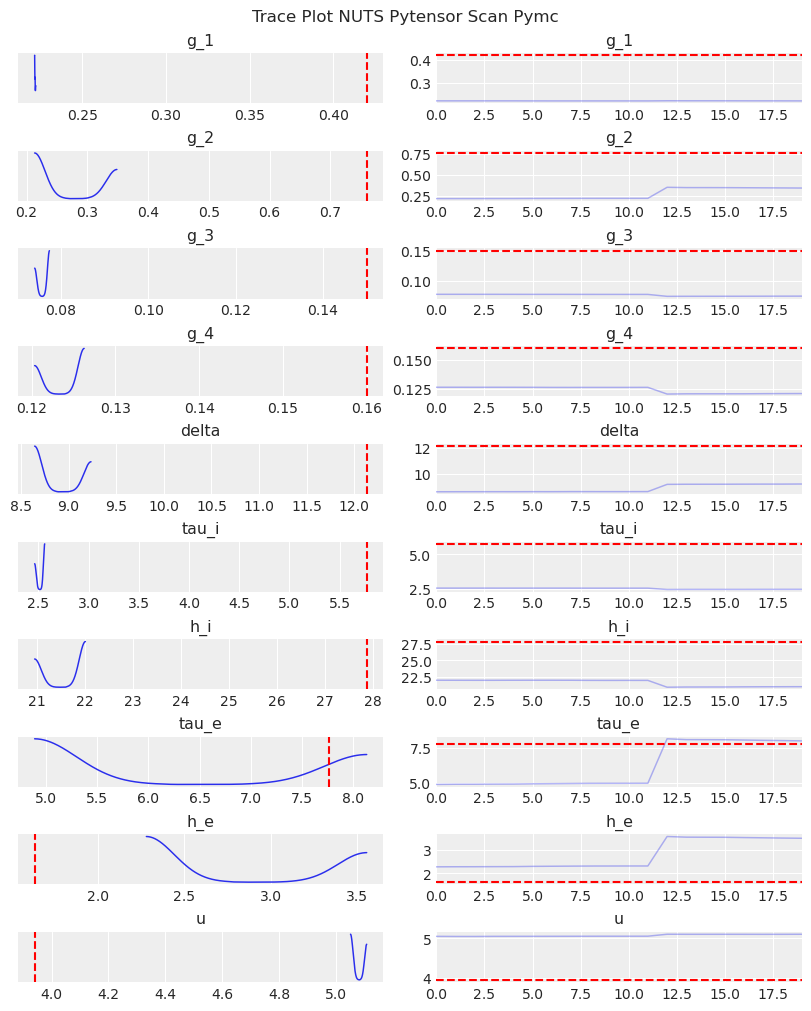

In [113]:
plot_trace(trace, my_var_names, theta_true, sampler);

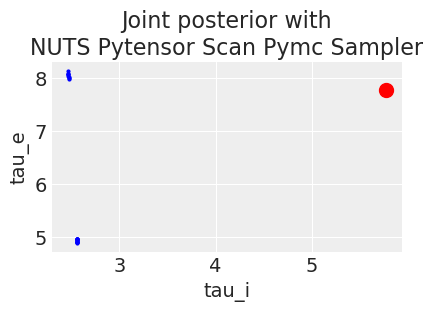

In [114]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

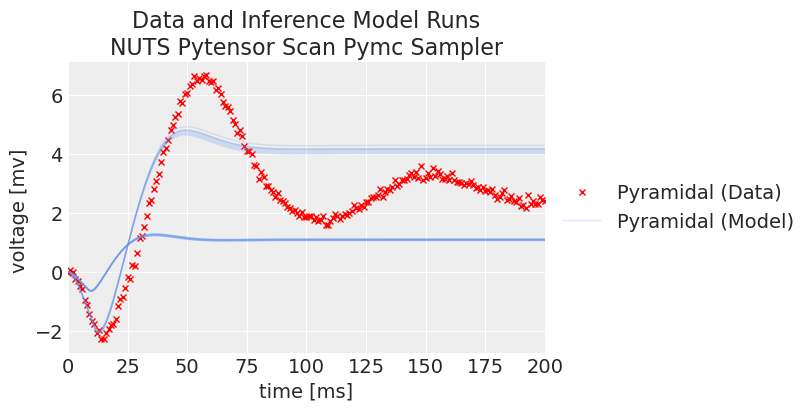

In [115]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [116]:
rmse_params_nuts_pytensor_scan_pymc, rmse_fit_nuts_pytensor_scan_pymc =rmse_fit(model, trace, data, theta_true)
print ('RMSE to true parameters', rmse_params_nuts_pytensor_scan_pymc),
print ('RMSE to true observation', rmse_fit_nuts_pytensor_scan_pymc)

RMSE to true parameters 165.79448573945052
RMSE to true observation 600.7934843710707


**Notes:**  
Still implemenation of NUTS with Pytensor scan is slow (around 1 hours for 800 samples), but at least we get converhgence and a decent fit.   

### NUTS Pytensor Scan Nutpie

In [117]:
model = model_scan_inference(theta)
sampler = "NUTS Pytensor Scan Nutpie"

start_time = time.time()
with model:
    trace_nuts_pytensor_scan_nutpie = pm.sample(nuts_sampler="nutpie", tune=tune, draws=draws, chains=n_chains,
                                                initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names},     
                                               )                                             
crudetime_nuts_pytensor_scan_nutpie =time.time() - start_time
print("---running took: %s seconds ---" % crudetime_nuts_pytensor_scan_nutpie)


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/sampling/mcmc.py:284: UserWarning: `initvals` are currently not passed to nutpie sampler. Use `init_mean` kwarg following nutpie specification instead.
  warnings.warn(


---running took: 1077.3314204216003 seconds ---


In [118]:
trace = trace_nuts_pytensor_scan_nutpie
az.summary(trace)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
delta         4.416   4.736   0.401   12.709      2.319    1.770       5.0   
delta_log__   0.826   1.228  -0.913    2.542      0.601    0.459       5.0   
g_1          16.375  25.519   0.375   60.596     12.502    9.545       5.0   
g_1_log__     1.221   1.788  -0.876    4.105      0.874    0.669       5.0   
g_2           1.855   0.799   0.600    2.813      0.391    0.299       5.0   
g_2_log__     0.487   0.561  -0.510    1.034      0.274    0.209       5.0   
g_3           5.984   9.972   0.101   23.244      4.885    3.730       5.0   
g_3_log__    -0.513   2.194  -2.291    3.146      1.070    0.816       5.0   
g_4           3.409   5.561   0.087   13.035      2.725    2.080       5.0   
g_4_log__    -0.624   1.880  -2.441    2.568      0.919    0.701       5.0   
h_e           4.180   1.836   1.790    6.514      0.895    0.683       5.0   
h_e_log__     1.318   0.492   0.582    1.874      0.239    0.183       5.0   
h_i          12.834   9.911   0.497   24.998      4.790    3.649       5.0   
h_i_log__     1.832   1.553  -0.699    3.219      0.758    0.579       5.0   
tau_e         3.433   2.594   0.570    7.760      1.270    0.970       5.0   
tau_e_log__   0.874   0.930  -0.562    2.049      0.456    0.348       5.0   
tau_i        14.335   9.852   5.039   28.678      4.679    3.555       5.0   
tau_i_log__   2.400   0.740   1.617    3.356      0.358    0.273       5.0   
u             1.599   1.224   0.028    3.747      0.586    0.446       5.0   
u_log__      -0.392   1.868  -3.572    1.321      0.914    0.698       5.0   

             ess_tail  r_hat  
delta            16.0   3.44  
delta_log__      16.0   3.44  
g_1              14.0   3.33  
g_1_log__        14.0   3.37  
g_2              14.0   3.28  
g_2_log__        14.0   3.28  
g_3              13.0   2.76  
g_3_log__        13.0   2.76  
g_4              14.0   3.17  
g_4_log__        14.0   3.17  
h_e              12.0   3.32  
h_e_log__        12.0   3.32  
h_i              19.0   2.60  
h_i_log__        19.0   2.60  
tau_e            34.0   2.96  
tau_e_log__      34.0   2.97  
tau_i            12.0   3.20  
tau_i_log__      12.0   3.20  
u                17.0   3.12  
u_log__          17.0   3.36

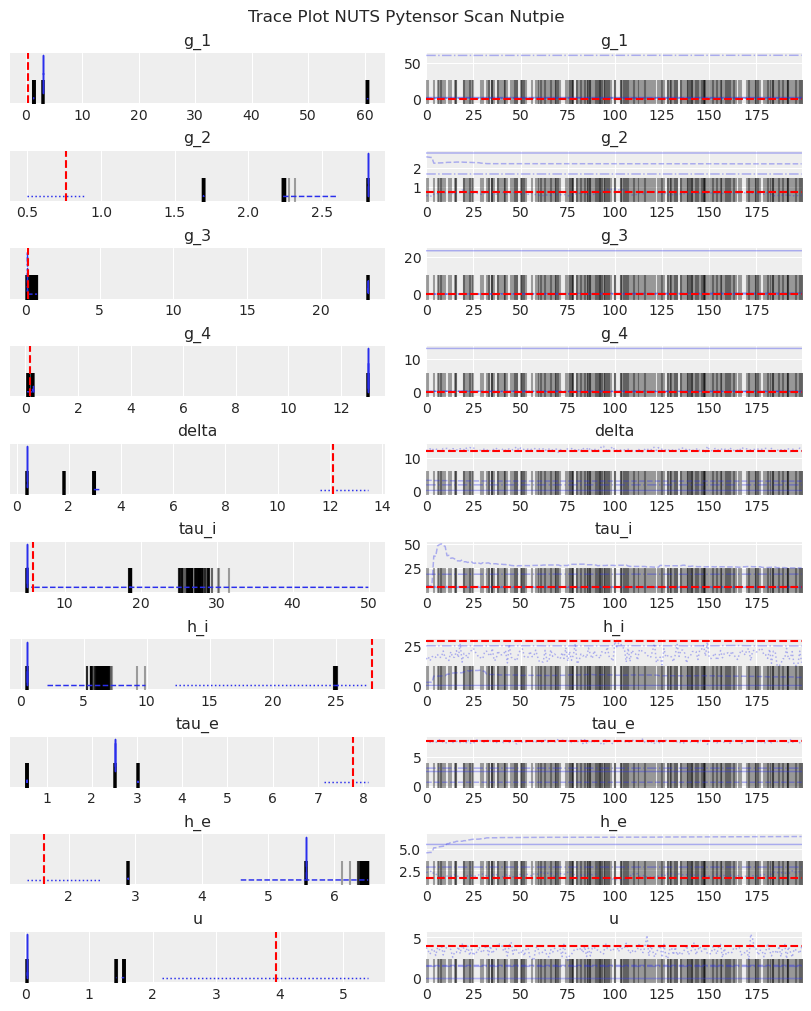

In [119]:
plot_trace(trace, my_var_names, theta_true, sampler);

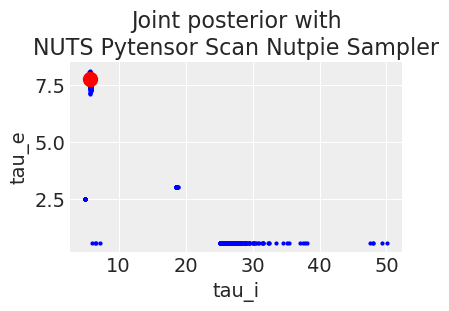

In [120]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

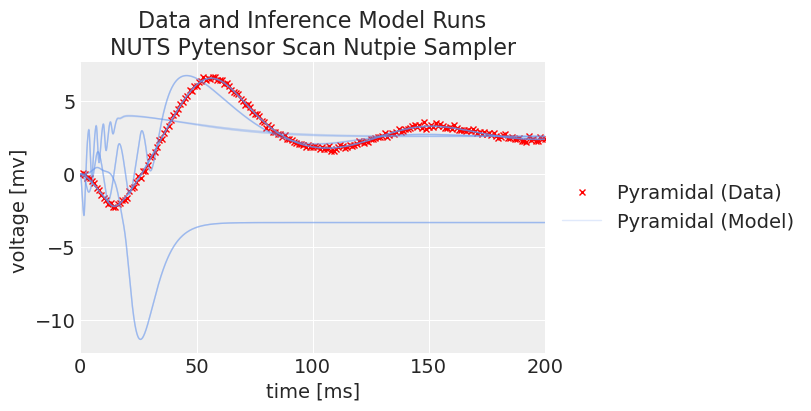

In [121]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [122]:
rmse_params_nuts_pytensor_scan_nutpie, rmse_fit_nuts_pytensor_scan_nutpie=rmse_fit(model, trace, data, theta_true)
print ('RMSE to true parameters', rmse_params_nuts_pytensor_scan_nutpie),
print ('RMSE to true observation', rmse_fit_nuts_pytensor_scan_nutpie)

RMSE to true parameters 61.12358709188086
RMSE to true observation 1536482.515754381


Still implemenation of NUTS with nutpie is much faster than alternavives.

### NUTS Pytensor Scan blackjax

In [123]:
model = model_scan_inference(theta)
sampler = "NUTS Pytensor Scan Balckjax"

start_time = time.time()
with model:
    trace_nuts_pytensor_scan_blackjax = pm.sample(nuts_sampler="blackjax", tune=tune, draws=draws, chains=n_chains,  progressbar=False,
                                            initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names},
                                            target_accept = 0.8,
                                            nuts = {"max_treedepth": 10},)
crudetime_nuts_pytensor_scan_blackjax =time.time() - start_time
print("---running took: %s seconds ---" % crudetime_nuts_pytensor_scan_blackjax)

/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


---running took: 78.79399037361145 seconds ---


In [124]:
trace = trace_nuts_pytensor_scan_blackjax
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  12.500  0.383  11.758   13.205      0.023    0.016     289.0     293.0   
g_1     0.518  0.121   0.326    0.766      0.005    0.003     623.0     351.0   
g_2     0.663  0.075   0.531    0.797      0.004    0.003     332.0     582.0   
g_3     0.140  0.021   0.100    0.180      0.001    0.001     356.0     292.0   
g_4     0.212  0.031   0.154    0.268      0.001    0.001     480.0     560.0   
h_e     1.905  0.213   1.557    2.323      0.012    0.008     333.0     504.0   
h_i    19.876  3.442  13.466   25.434      0.154    0.109     494.0     567.0   
tau_e   7.605  0.210   7.164    7.972      0.012    0.009     292.0     324.0   
tau_i   5.765  0.070   5.645    5.899      0.002    0.002    1108.0     645.0   
u       3.329  0.537   2.427    4.340      0.024    0.017     502.0     564.0   

       r_hat  
delta   1.01  
g_1     1.01  
g_2     1.01  
g_3     1.00  
g_4     1.00  
h_e     1.01  
h_i     1.00  
tau_e   1.01  
tau_i   1.01  
u       1.01

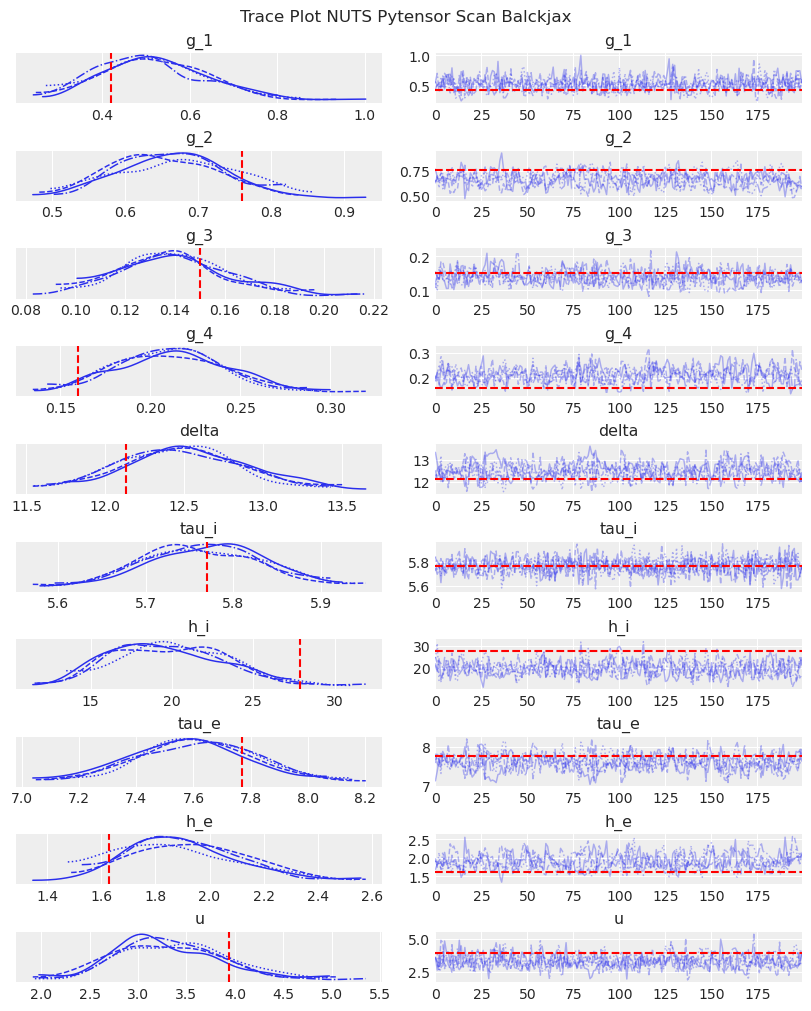

In [125]:
plot_trace(trace, my_var_names, theta_true, sampler);

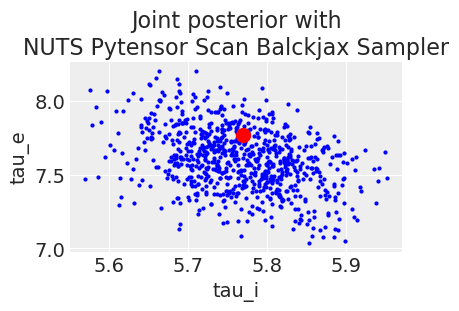

In [126]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

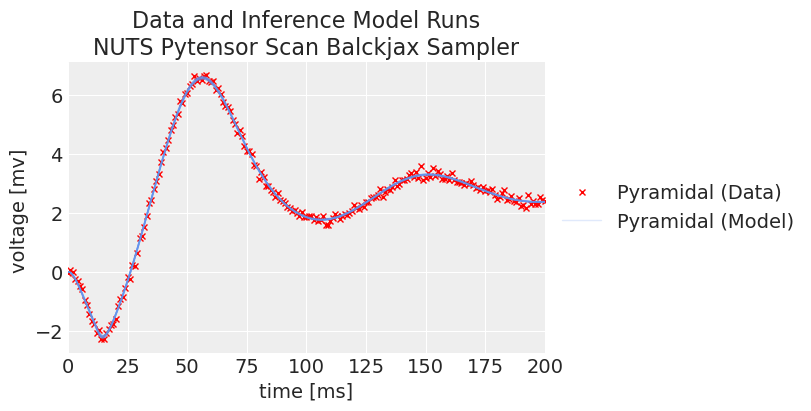

In [127]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [128]:
rmse_params_nuts_pytensor_scan_blackjax, rmse_fit_nuts_pytensor_scan_blackjax=rmse_fit(model, trace, data, theta_true)
print ('RMSE to true parameters', rmse_params_nuts_pytensor_scan_blackjax),
print ('RMSE to true observation', rmse_fit_nuts_pytensor_scan_blackjax),

RMSE to true parameters 65.40976642173402
RMSE to true observation 2.811011170725028


(None,)

**Notes:**  
This implemenation of NUTS with blackjax is very very fast, and we got the convergence, and a perfect fit.   

### NUTS Pytensor Scan Numpyro

In [129]:
model = model_scan_inference(theta)
sampler = "NUTS Pytensor Scan Numpyro"

start_time = time.time()

with model:
    trace_nuts_pytensor_scan_numpyro = pm.sample(nuts_sampler="numpyro", tune=tune, draws=draws, chains=n_chains,  
                                                initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names}, 
                                                target_accept = 0.8,
                                                nuts = {"max_treedepth": 10},)
crudetime_nuts_pytensor_scan_numpyro =time.time() - start_time
print("---running took: %s seconds ---" % crudetime_nuts_pytensor_scan_numpyro)

Compiling.. :   0%|                                     | 0/400 [00:00<?, ?it/s]

  0%|                                                   | 0/400 [00:00<?, ?it/s]

Compiling.. :   0%|                                     | 0/400 [00:00<?, ?it/s]


  0%|                                                   | 0/400 [00:00<?, ?it/s]


Running chain 1:   0%|                                  | 0/400 [00:04<?, ?it/s]


Running chain 0:   0%|                                  | 0/400 [00:04<?, ?it/s]

Running chain 2:   0%|                                  | 0/400 [00:04<?, ?it/s]


Running chain 3:  10%|██▍                     | 40/400 [00:04<00:00, 373.02it/s]

Running chain 2:  10%|██▍                     | 40/400 [00:04<00:01, 352.13it/s]

Running chain 2:  20%|████▊                   | 80/400 [00:05<00:00, 344.18it/s]


Running chain 0:  10%|██▌                      | 40/400 [00:08<00:40,  8.93it/s]


Running chain 1:  10%|██▌                      | 40/400 [00:10<00:53,  6.68it/s]

Running ch

---running took: 83.11202812194824 seconds ---


In [130]:
trace.sample_stats.tree_depth.max().values

array(10)

In [131]:
trace.sample_stats.acceptance_rate.mean().values

array(0.93382842)

In [132]:
trace = trace_nuts_pytensor_scan_numpyro
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  12.483  0.379  11.776   13.173      0.020    0.014     359.0     339.0   
g_1     0.526  0.118   0.313    0.746      0.004    0.003     720.0     483.0   
g_2     0.660  0.077   0.518    0.792      0.004    0.003     328.0     378.0   
g_3     0.139  0.020   0.101    0.175      0.001    0.001     452.0     396.0   
g_4     0.215  0.033   0.153    0.275      0.001    0.001     648.0     516.0   
h_e     1.914  0.220   1.483    2.290      0.012    0.008     333.0     391.0   
h_i    19.538  3.222  14.004   26.108      0.145    0.103     473.0     393.0   
tau_e   7.615  0.207   7.228    7.996      0.011    0.008     359.0     379.0   
tau_i   5.763  0.066   5.649    5.893      0.002    0.002     978.0     484.0   
u       3.364  0.586   2.233    4.350      0.026    0.018     504.0     489.0   

       r_hat  
delta   1.00  
g_1     1.01  
g_2     1.01  
g_3     1.01  
g_4     1.01  
h_e     1.01  
h_i     1.01  
tau_e   1.00  
tau_i   1.00  
u       1.00

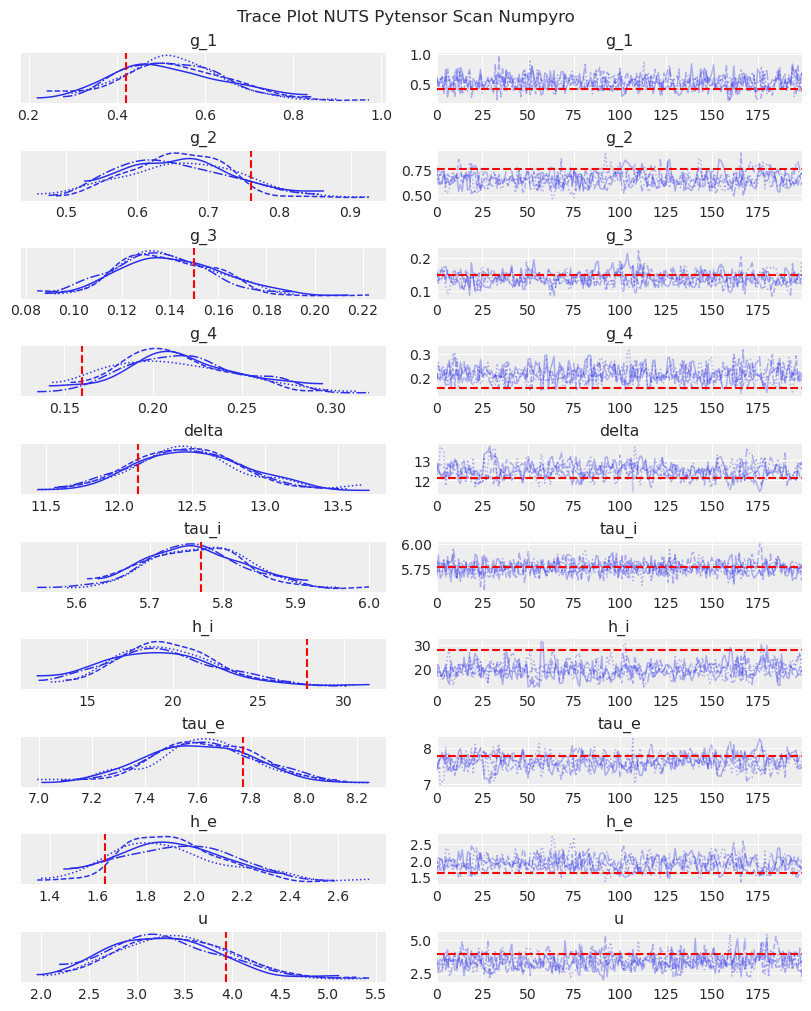

In [133]:
plot_trace(trace, my_var_names, theta_true, sampler);

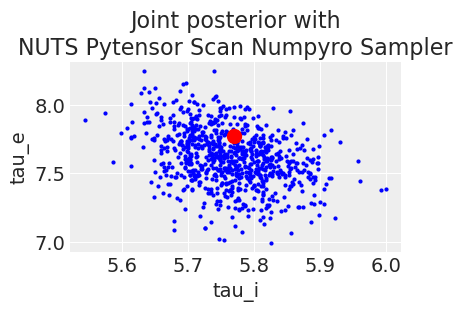

In [134]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

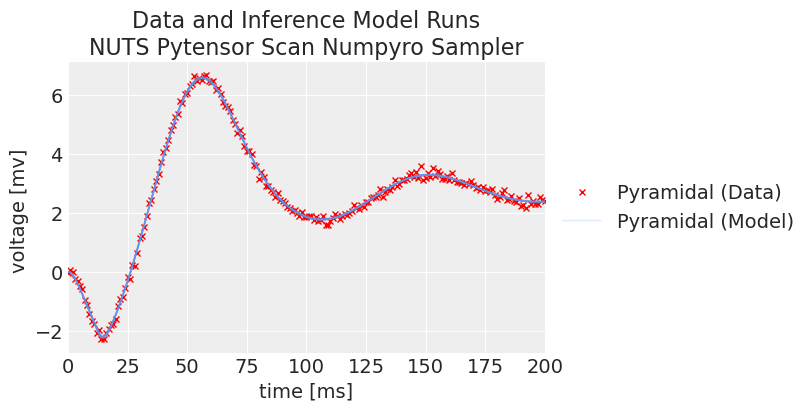

In [135]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [136]:
rmse_params_nuts_pytensor_scan_numpyro, rmse_fit_nuts_pytensor_scan_numpyro=rmse_fit(model, trace, data, theta_true)
print ('RMSE to true parameters', rmse_params_nuts_pytensor_scan_numpyro),
print ('RMSE to true observation', rmse_fit_nuts_pytensor_scan_numpyro)

RMSE to true parameters 70.26166664890917
RMSE to true observation 2.764190714326163


***Notes:*** 

Note that using JIT, such as JAX's JIT, in NumPyro will provide a much faster sampler (at least an order of magnitude faster) since we can also make the model simuations much faster.

## Summary

Let's compare inference results among these different methods.  Recall that, in order to run this notebook in a reasonable amount of time, we have an insufficient number of samples for many inference methods.  For a fair comparison, we would need to bump up the number of samples and run the notebook for longer.  In sum, we have seen better convergence for gradient-based samplers compared to gradient free, and NUTS with blackjax was winner by speed and convergence.    

In [137]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])

In [138]:
model_names = [
    "Slice Sampler",
    "Metropolis",
    "DE MetropolisZ",
    "DE Metropolis",
    "SMC Likelihood",
    "SMC e=1",
    "SMC e=10",
    "NUTS PyMC ODE",
    "NUTS Pytensor",
    "NUTS Nutpie",
    "NUTS Blackjax",
    "NUTS Numpyro",
]

In [139]:
inference_results = [
    trace_slice,
    trace_M,
    trace_DEMZ,
    trace_DEM,
    trace_SMC_like,
    trace_SMC_e1,
    trace_SMC_e10,
    trace_nuts_pymc_ode,
    trace_nuts_pytensor_scan_pymc,
    trace_nuts_pytensor_scan_nutpie,
    trace_nuts_pytensor_scan_blackjax,
    trace_nuts_pytensor_scan_numpyro,
]

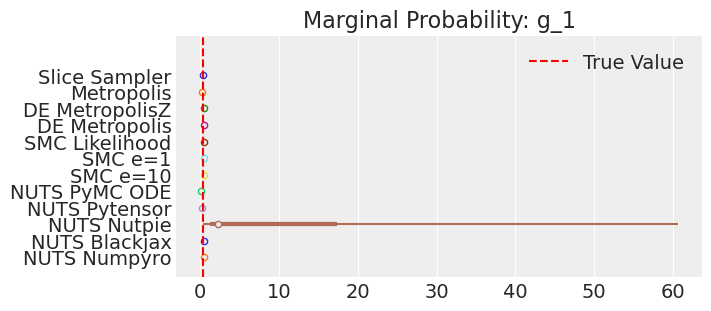

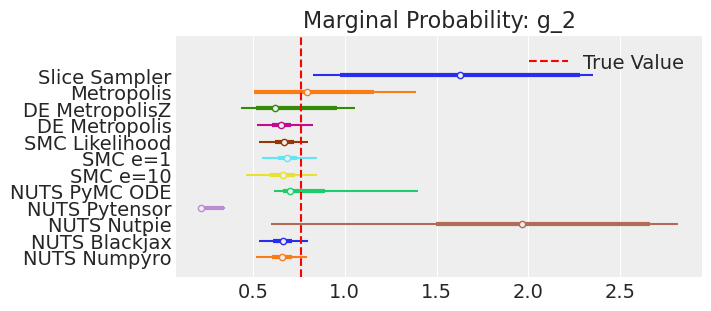

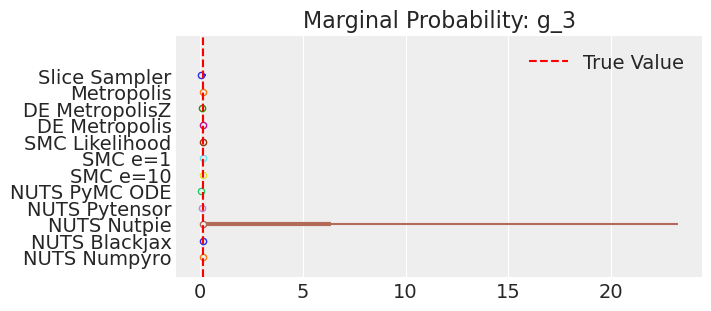

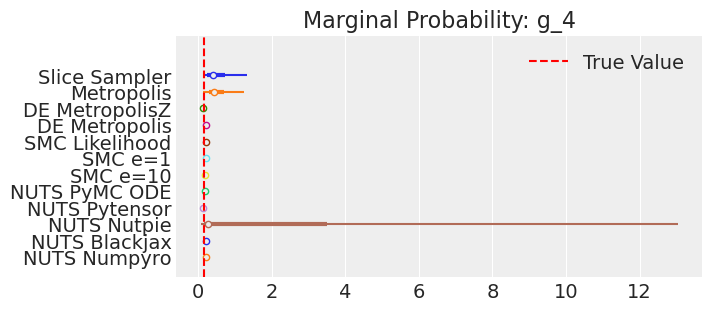

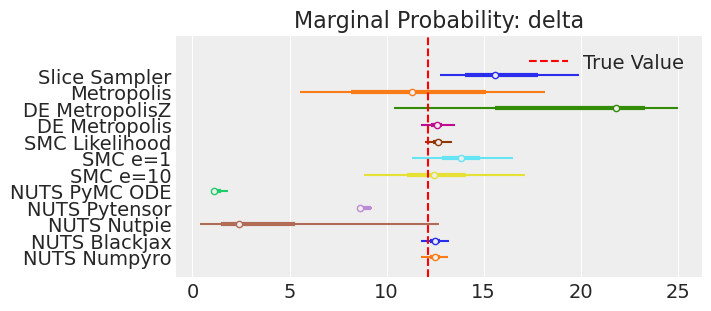

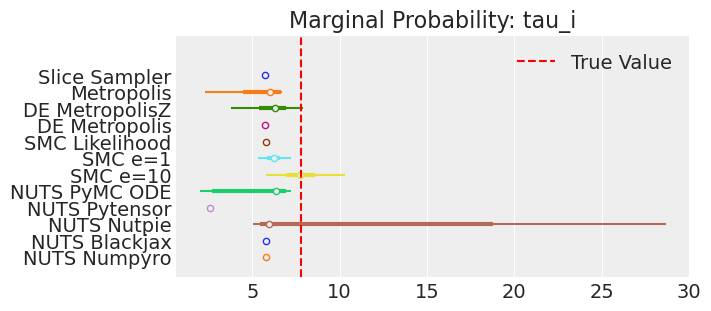

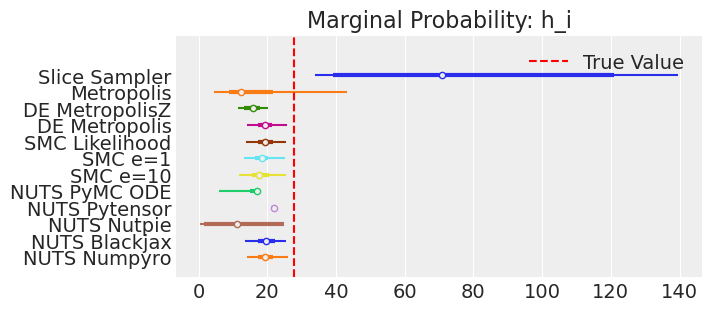

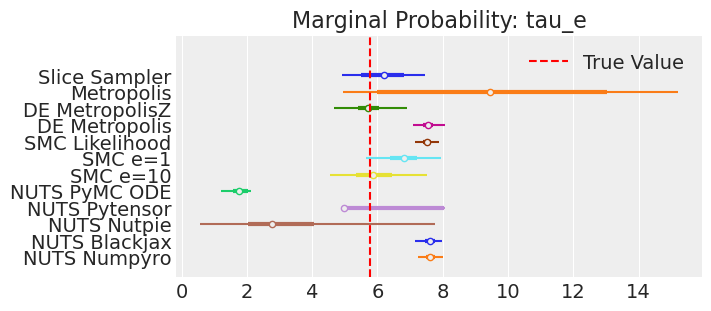

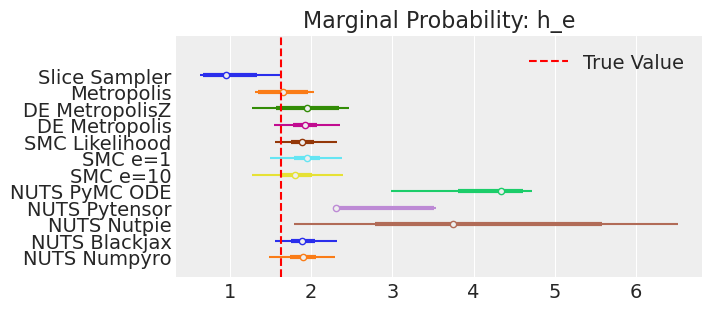

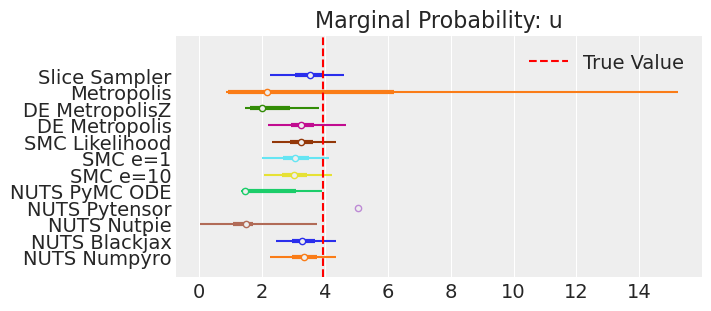

In [140]:
for var_name, true_value in zip(my_var_names, theta_true):
    axes = az.plot_forest(
        inference_results,
        model_names=model_names,
        var_names=var_name,
        kind="forestplot",
        legend=False,
        combined=True,
        figsize=(7, 3),)
    
    for ax in axes:
        ax.axvline(true_value, color='red', linestyle='--', label='True Value')
        ax.set_title(f"Marginal Probability: {var_name}")
        ylabels = ax.get_yticklabels()
        new_ylabels = []
        for label in ylabels:
            txt = label.get_text()
            txt = txt.replace(": " + var_name, "")
            label.set_text(txt)
            new_ylabels.append(label)
        ax.set_yticklabels(new_ylabels)
        ax.legend(loc='upper right')
    
plt.show()


In [141]:
inference_ess_bulk = [
    az.ess(trace, method="bulk").to_array().values.mean() /30 if model_name == "DE Metropolis"
    else az.ess(trace, method="bulk").to_array().values.mean() *40 if model_name == "NUTS PyMC ODE"    
    else az.ess(trace, method="bulk").to_array().values.mean() *40 if model_name == "NUTS Pytensor"    
    else az.ess(trace, method="bulk").to_array().values.mean()
    for model_name, trace in zip(model_names, inference_results)]


In [142]:
inference_ess_tail = [
    az.ess(trace, method="tail").to_array().values.mean() /30 if model_name == "DE Metropolis"
    else az.ess(trace, method="tail").to_array().values.mean() *40 if model_name == "NUTS PyMC ODE"    
    else az.ess(trace, method="tail").to_array().values.mean() *40 if model_name == "NUTS Pytensor"    
    else az.ess(trace, method="tail").to_array().values.mean()
    for model_name, trace in zip(model_names, inference_results)]


In [143]:
inference_data_ess = {
    model_names[i]: {
        "ess_tails_bulk": inference_ess_bulk[i],
        "ess_tails_tail": inference_ess_tail[i],} 
                    for i in range(len(model_names))}

df_ess = pd.DataFrame.from_dict(inference_data_ess, orient='index')

In [144]:
crudetime_values= [crudetime_slice, crudetime_M, crudetime_DEMZ, crudetime_DEM, 
                       crudetime_SMC_like, crudetime_SMC_e1, crudetime_SMC_e10, 
                       40*crudetime_nuts_pymc_ode, 
                       4*crudetime_nuts_pytensor_scan_pymc, 
                       crudetime_nuts_pytensor_scan_nutpie, 
                       crudetime_nuts_pytensor_scan_blackjax, 
                       crudetime_nuts_pytensor_scan_numpyro] 


rmse_params_values = [
    rmse_params_slice, rmse_params_M,  rmse_params_DEMZ, rmse_params_DEM, 
    rmse_params_SMC_like, rmse_params_SMC_e1, rmse_params_SMC_e10, 
    rmse_params_nuts_pymc_ode, 
    rmse_params_nuts_pytensor_scan_pymc, 
    rmse_params_nuts_pytensor_scan_nutpie,
    rmse_params_nuts_pytensor_scan_blackjax, 
    rmse_params_nuts_pytensor_scan_numpyro
]

rmse_fit_values = [
    rmse_fit_slice, rmse_fit_M, rmse_fit_DEMZ, rmse_fit_DEM, 
    rmse_fit_SMC_like, rmse_fit_SMC_e1, rmse_fit_SMC_e10, 
    rmse_fit_nuts_pymc_ode,
    rmse_fit_nuts_pytensor_scan_pymc, 
    rmse_fit_nuts_pytensor_scan_nutpie,
    rmse_fit_nuts_pytensor_scan_blackjax, 
    rmse_fit_nuts_pytensor_scan_numpyro
]

/tmp/ipykernel_329122/1563144988.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=90)
/tmp/ipykernel_329122/1563144988.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=90)
/tmp/ipykernel_329122/1563144988.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=90)
/tmp/ipykernel_329122/1563144988.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=90)


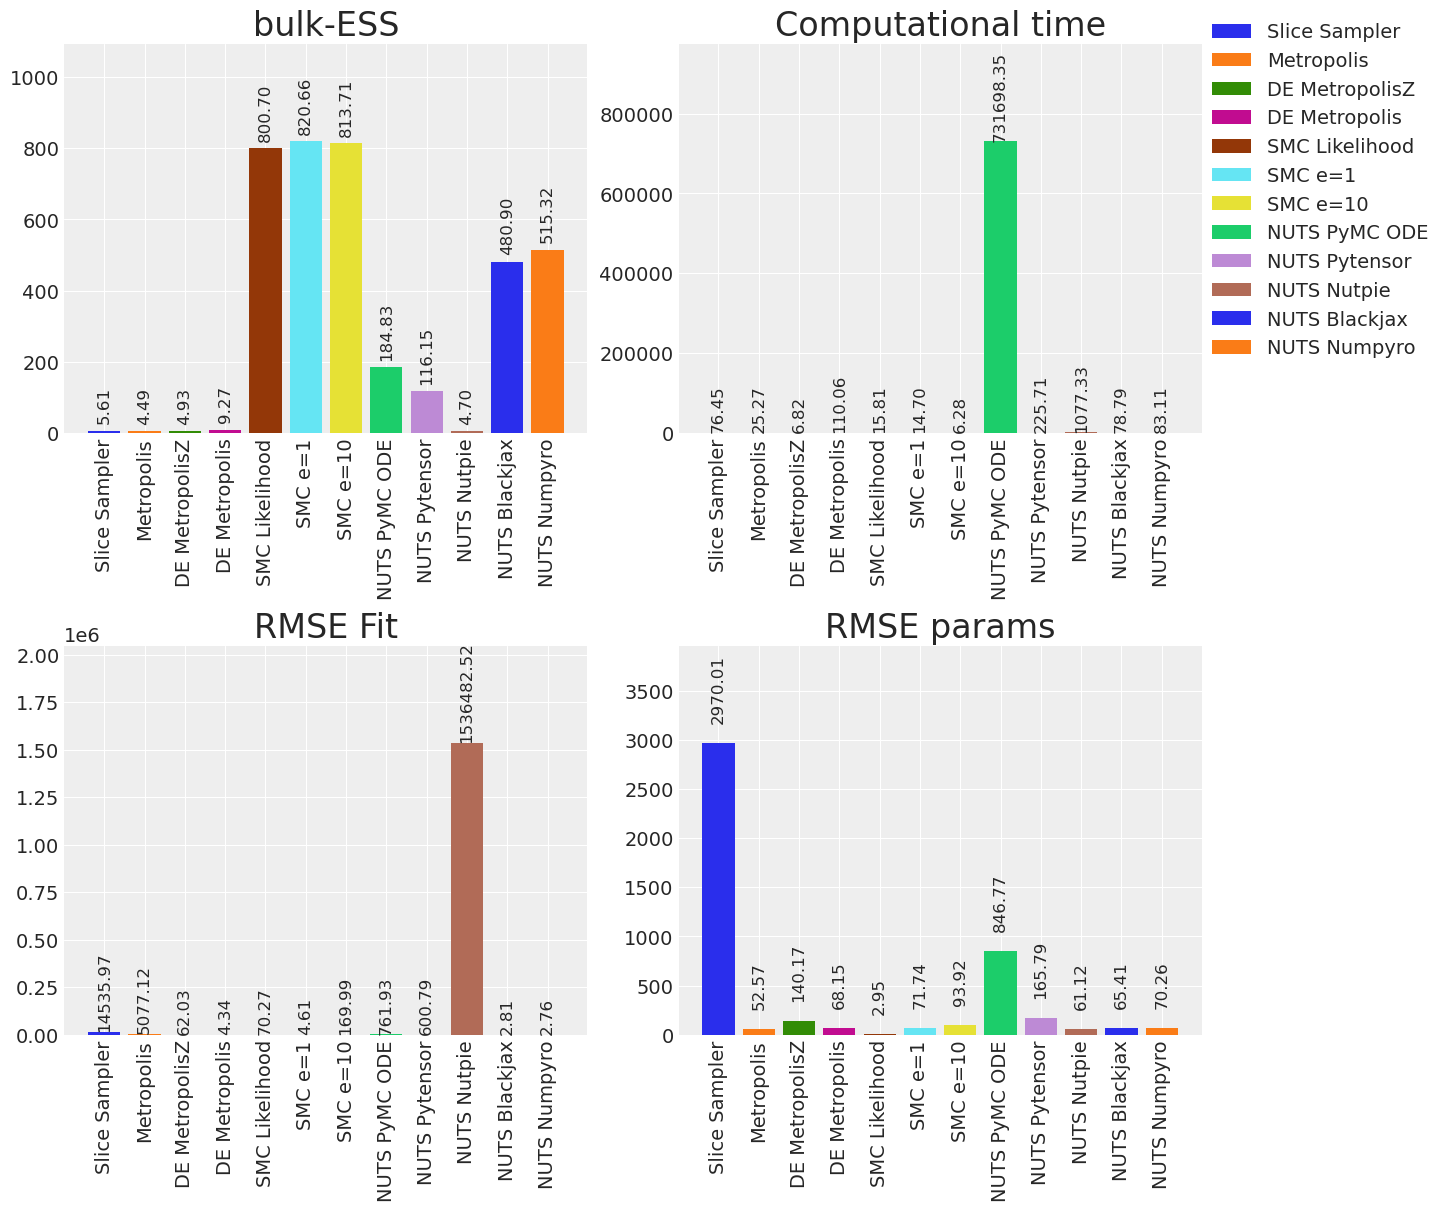

In [145]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot 1: Bulk effective sample size (bulk-ESS)
for i, (name, data) in enumerate(zip(model_names, inference_ess_bulk)):
    ax = axes[0, 0] if i < len(model_names) // 2 else axes[0, 0]
    ax.bar(name, data, label=name)
    ax.text(i, data + 20, f'{data:.2f}', ha='center', va='bottom', rotation=90, fontsize=12)
ax.set_title('bulk-ESS' , fontsize=24)
ax.set_xticklabels(model_names, rotation=90)
ax.set_ylim(0, (4/3)*np.max(inference_ess_bulk))

# Plot 2: Computational time
for i, (name, data) in enumerate(zip(model_names, crudetime_values)):
    ax = axes[0, 1] if i < len(model_names) // 2 else axes[0, 1]
    ax.bar(name, data, label=name)
    ax.text(i, data + 50, f'{data:.2f}', ha='center', va='bottom', rotation=90, fontsize=12)
ax.set_title('Computational time', fontsize=24)
ax.set_xticklabels(model_names, rotation=90)
ax.set_ylim(0, (4/3)*np.max(crudetime_values))

# Plot 3: RMSE fit
for i, (name, data) in enumerate(zip(model_names, rmse_fit_values)):
    ax = axes[1, 0] if i < len(model_names) // 2 else axes[1, 0]
    ax.bar(name, data, label=name)
    ax.text(i, data + 500, f'{data:.2f}', ha='center', va='bottom', rotation=90, fontsize=12)
ax.set_title('RMSE Fit', fontsize=24)
ax.set_xticklabels(model_names, rotation=90)
ax.set_ylim(0, (4/3)*np.max(rmse_fit_values))

# Plot 4: RMSE params
for i, (name, data) in enumerate(zip(model_names, rmse_params_values)):
    ax = axes[1, 1] if i < len(model_names) // 2 else axes[1, 1]
    ax.bar(name, data, label=name)
    ax.text(i, data + 200, f'{data:.2f}', ha='center', va='bottom', rotation=90, fontsize=12)
ax.set_title('RMSE params', fontsize=24)
ax.set_xticklabels(model_names, rotation=90)
ax.set_ylim(0, (4/3)*np.max(rmse_params_values))

fig.legend(model_names, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()

In [146]:
Metrics_eval_data = {}
for i, model_name in enumerate(model_names):
    Metrics_eval_data[model_name] = {
        "ess_tails_bulk": inference_ess_bulk[i],
        "ess_tails_tail": inference_ess_tail[i],
        "crudetime": crudetime_values[i],
        "rmse_params": rmse_params_values[i],
        "rmse_fit": rmse_fit_values[i]}

In [147]:
df_metrics = pd.DataFrame.from_dict(Metrics_eval_data, orient='index')
df_metrics

ess_tails_bulk  ess_tails_tail      crudetime  rmse_params  \
Slice Sampler         5.610764       25.011413      76.453897  2970.013736   
Metropolis            4.492299        7.432929      25.274076    52.570136   
DE MetropolisZ        4.926708       12.138562       6.815014   140.169066   
DE Metropolis         9.274532        6.883674     110.060631    68.151027   
SMC Likelihood      800.701894      743.618786      15.811017     2.954716   
SMC e=1             820.664736      776.227260      14.696002    71.739591   
SMC e=10            813.708208      744.837401       6.276702    93.919040   
NUTS PyMC ODE       184.828338      941.915228  731698.347759   846.771098   
NUTS Pytensor       116.154932      900.052329     225.713622   165.794486   
NUTS Nutpie           4.702544       16.467256    1077.331420    61.123587   
NUTS Blackjax       480.899727      468.253546      78.793990    65.409766   
NUTS Numpyro        515.324760      424.769433      83.112028    70.261667   

                    rmse_fit  
Slice Sampler   1.453597e+04  
Metropolis      5.077122e+03  
DE MetropolisZ  6.203255e+01  
DE Metropolis   4.339916e+00  
SMC Likelihood  7.027184e+01  
SMC e=1         4.614002e+00  
SMC e=10        1.699948e+02  
NUTS PyMC ODE   7.619281e+02  
NUTS Pytensor   6.007935e+02  
NUTS Nutpie     1.536483e+06  
NUTS Blackjax   2.811011e+00  
NUTS Numpyro    2.764191e+00

**Notes:**  
If we ran the gradient-based  samplers for long enough to get good inferences, we would expect them to converge on the same posterior probability distributions. This is not necessarily true for Aproximate Bayssian Computation or gradient-free (with such a dimention and degeneracy). 

In sum, the results indicates SMC is a winner in gradient-free samplers, but needs tunning the acceptance rate. 
For the use of gradient-based, the  NUTS implementation with Pytensor Scan and the sampling from JAX's family such as blackjax and Numpyro is the winner.

In this notebook we ran all samplers with initial condition at mean prior. Neverthelss, the multimodality will happen with random initializaton. In this case, wighted stacking the chains is a robust solution.

### Key Conclusions
We performed Bayesian inference on a system of ODEs in 4 main ways: 
* Scipy `odeint` wrapped in a Pytensor `op` and sampled with non-gradient-based samplers (comparing 5 different samplers).  
* Scipy `odeint` wrapped in a `pm.Simulator` function and sampled with a non-likelihood-based sequential Monte Carlo (SMC) sampler.  
* PyMC `ode.DifferentialEquation` sampled with NUTs.  
* Forward simulation using `pytensor.scan` and sampled with NUTs (pymc, nutpie, and blackjax).  

The "winner" for this problem was Pytensor Pytensor Scan NUTs using Blackjax/Numpyro.


## Watermark

In [148]:
%watermark -n -u -v -iv -w

Last updated: Sat Apr 27 2024

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.15.0

pandas    : 2.2.1
arviz     : 0.18.0
sys       : 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC 10.4.0]
numpy     : 1.25.2
matplotlib: 3.6.2
pymc      : 5.11.0
pytensor  : 2.18.6

Watermark: 2.4.3



### Installation

In [149]:
#conda create -c conda-forge -n pymc_env "pymc>=5"
#conda activate pymc_env
#conda install -c anaconda ipykernel
#pip install nutpie
#pip install numba
#pip install numpyro
#pip install blackjax
#pip install watermark
#sudo apt-get install graphviz

#in the case of conflict for samplers
#pip install pymc==5.11.0
#pip install numpy==1.26.
